In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import calendar
from pandas.tseries import offsets
from datetime import date
import matplotlib.ticker as tkr
# import holidays
from scipy.stats import mstats
import math

%matplotlib inline  

blues = [x for x in reversed(sns.color_palette("Blues_d", 11))]
sns.set_palette(sns.color_palette("Paired", 10))
sns.set_style("white")
# sns.set_context("notebook", font_scale=3)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.weight']= "normal"
plt.rcParams["axes.labelweight"] = "normal"
season_dict = {"Winter":1, "Spring":2, "Summer":3, 'High Summer':4, "Autumn":5}
fig_format = "png"
# uk_hol= holidays.UK() #load UK holiday

In [2]:
import os
print(os.getcwd())
computer_path= ""
for x in os.getcwd().split(os.path.sep):
    print(x)
    computer_path=computer_path+x+os.path.sep
    if x == "OneDrive - Cardiff University":
        break    
print(computer_path)

C:\Users\sceac10\OneDrive - Cardiff University\05 - Python\03 - FLEXIS
C:
Users
sceac10
OneDrive - Cardiff University
C:\Users\sceac10\OneDrive - Cardiff University\


In [3]:
path=computer_path+ r"/04 - Projects/10 - Papers and conferences/02 - ECOS conference/Heat-pumps data/csv/"
path_save=computer_path+r"/04 - Projects/10 - Papers and conferences/02 - ECOS conference/02 - Analysis/01 - Results/"

In [4]:
def prepareData(data):
    data["Date"]= data["Year"].map(str)+"/"+data["Month"].map(str)+"/"+data["Day"].map(str)
    data["Date"] = pd.to_datetime(data["Date"]+ " "+data["Hour"].map(str)+":"+ data["Minute"].map(str) , format="%Y%m%d %H:%M")
    data.drop(["Matlab_time"], axis=1, inplace=True)
    data.sort_values("Date", inplace=True)
    data.set_index("Date", inplace=True)

    
def ExtractAndMerge(path):
    frames = []

    for fn in os.listdir(path):
        print(fn)
        print(fn)
        if os.path.splitext(fn)[1]==".csv":
            data = pd.read_csv(path+fn)
            frames.append(data)

    result = pd.concat(frames,axis=0)
    return result


def ExtractAndMergeHP(path):
    frames = []
    count=0
    for fn in os.listdir(path):
        if count<600:
            if os.path.splitext(fn)[1]==".csv":

                data = pd.read_csv(path+fn)
                ref=os.path.splitext(fn)[0].split('_')[1]
        #             print(data.shape)
                prepareData(data)
                    # # Convert to kW
                data.dropna(how="any", subset=["Ehp"], inplace=True)
                data.loc[:, ["Ehp", "Edhw", "Esp", "Eboost"]]=data.loc[:, ["Ehp", "Edhw", "Esp", "Eboost"]]*30/1000
                data=data.loc[:, ["Ehp", "Edhw", "Esp", "Eboost"]].resample('30min').mean()
                find_fill_outliers(data, "Ehp", True, True)
                data["Ehp"]= normalize_serie(data["Ehp"])
                data["Ref"]=ref.upper()
                frames.append(data)
                count=count+1

    result = pd.concat(frames,axis=0)
    return result

def normalize_serie(x):
    z = (x-x.min())/(x.max()-x.min())
    return z

def addTimePeriod(data):
    data["Hour"] = data.index.hour
    data["DayOfWeek_name"]= [calendar.day_name[x] for x in data.index.dayofweek]
    data["DayOfWeek"]= data.index.dayofweek
    data["Day"]= data.index.dayofyear
    data["Month"] =data.index.month
    data["Year"] =data.index.year
    data["Month name"] = [calendar.month_name[x] for x in data["Month"]]
    data["Weekday"] = [1 if x<5 else 0 for x in data.index.dayofweek]
    data["HH"] = [x%48 for x in range(0, data.shape[0], 1) ]
    data["Date"] = data.index.date
    data["Week"] = data.index.week

    inv_season_dict = {v: k for k, v in season_dict.items()}
    data['Season'] = data.apply(get_season, axis=1)
    data['Season num'] = data['Season']
    data.replace({"Season num":season_dict}, inplace=True)

def get_season(row):
    if row['Month'] >= 4 and row['Month'] <= 5: #April and May
        return 'Spring'
    elif row['Month'] >= 6 and row['Month'] <= 6: # June
        return 'Summer'
    elif row['Month'] >= 7 and row['Month'] <= 8: # July and August
        return 'High Summer'
    elif row['Month'] >= 9 and row['Month'] <= 10: # September and October
        return 'Autumn'
    else:
        return 'Winter'
    
    
def find_fill_outliers(df, serie_name, rolling, fillna):
    #4 sigma rules and 6 hours window
    df[serie_name +" zscore"]=0
    if rolling:
        df[serie_name +" zscore"]= rolling_zscore(df[serie_name], 12)
        df[serie_name +" zscore"].fillna(zscore(df[serie_name]), inplace=True)
    else:
        df[serie_name +" zscore"]=zscore(df[serie_name])
    df.loc[abs(df[serie_name+" zscore"])>4, serie_name]=np.nan
    df.drop(serie_name +" zscore", axis=1, inplace=True)
    if fillna:
        df[serie_name].fillna(df[serie_name].rolling(window=6, center=True, min_periods=3).mean(), inplace=True)
        df[serie_name].interpolate(inplace=True)
    
def zscore(x):
    z=(x-x.mean())/x.std()
    return z
    
def rolling_zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

In [5]:
def display_clusters(df, nb_clusters, cluster_centers, file_name):
    color=sns.color_palette("Set2", 10)
    fig, ax = plt.subplots(figsize=(28, 10))
    idx = pd.IndexSlice
    x=[val for val in range(0, df.shape[1],1)]
    for n_cluster in range(nb_clusters):
        nb_item= df.index.get_level_values(1).value_counts()[n_cluster]
        if nb_item>1:
#             df.loc[idx[:, n_cluster], :].T.plot(ax=ax, c=color[n_cluster], alpha=0.8, linewidth=0.5)
            y1 = df.loc[idx[:, n_cluster], :].quantile(0.05, axis=0).values
            y2 = df.loc[idx[:, n_cluster], :].quantile(0.95, axis=0).values
            ax.fill_between(x, y1, y2, color=color[n_cluster], alpha=0.5)
            plt.plot(x, cluster_centers[n_cluster], color=color[n_cluster], alpha=1, label="cluster "+str(n_cluster+1)+" Obs:"+str(nb_item))

#     ax.legend_.remove()
#     ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_xlabel("Time [h]", fontsize=24)
    ax.set_ylabel("Energy content per hour [kWh]", fontsize=24)
    lines, labels = ax.get_legend_handles_labels()
    new_lines =[]
    new_labels =[]
    for x in range(len(labels)):
        if "cluster" in labels[x]:
            new_labels.append(labels[x])
            new_lines.append(lines[x])

    lgd = ax.legend(new_lines, new_labels,prop={'size':24}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.margins(0,None)
#     plt.savefig(path+ "cluster " +file_name+"."+fig_format, bbox_inches='tight',format=fig_format, dpi=1000) 
    plt.show()
    plt.close(fig)
    return y1, y2

In [6]:
from sklearn.cluster import KMeans
from sklearn import metrics

def cluster(values, max_cluster):
    algorithm = "elkan"
    min_silhouette_avg = 0.
    cluster_centers=[]
    cluster_labels=[]
    for n_clusters in range(2, max_cluster, 1):
        print(n_clusters)
        kmeans = KMeans(n_clusters=n_clusters, random_state=10, algorithm="elkan", n_init=30).fit(values)
        labels_temp= kmeans.labels_
        silhouette_avg = metrics.silhouette_score(values, labels_temp)
        
        silhouette_samples_values = metrics.silhouette_samples(values, labels_temp)
        calinski_harabaz_score= metrics.calinski_harabaz_score(values, labels_temp)
        nb_values_over = 0
        print("cluster:", n_clusters , "silhouette score:" ,silhouette_avg, "calinski_harabaz:",calinski_harabaz_score )
        if min_silhouette_avg<silhouette_avg:
            min_silhouette_avg=silhouette_avg
            cluster_centers= kmeans.cluster_centers_
            cluster_labels= labels_temp

        for cluster in range(n_clusters):
            cluster_values = silhouette_samples_values[cluster_labels==cluster]
            nb_values_over = nb_values_over+ len(cluster_values[np.where(cluster_values>silhouette_avg)])
        print("Number of values over average:", nb_values_over, "({:04.1f}%)".format(nb_values_over/len(values)*100)) 
        
    return cluster_centers.shape[0], cluster_centers, cluster_labels

In [7]:
metadata=pd.read_excel(computer_path+r"/04 - Projects/10 - Papers and conferences/02 - ECOS conference/Heat-pumps data/rhpp_metadata.xlsx")
metadata.head()

,Site.ID,Heat.pump.type,Site.type,Property.Type,Age.of.property,Number.of.bedrooms,Emitter.type,Schematic.as.documented,Schematic.version,Nearest.equivalent.V2.1.schematic,...,Intervention.2,Comment.2,Date.3,Intervention.3,Comment.3,Document.Location.3,Date.4,Intervention.4,Comment.4,Document.Location.4
0,RHPP5504,ASHP,Domestic,Detached house,1981-2000,3,Radiators,2,V1.0,2.40,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,RHPP5457,ASHP,Domestic,Semi detached house,1965-1980,3,Radiators,4c,V1.0,4.10,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,RHPP5188,GSHP,Domestic,Detached house,1945-1964,3,Radiators,16,V1.0,16.12,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
3,RHPP5434,ASHP,Domestic,End terraced house,1945-1964,3,Radiators,2,V1.0,2.40,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
4,RHPP5467,ASHP,Domestic,Detached house,Pre 1919,4+,Radiators,2,V1.0,2.40,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN


Matlab_time	Time of measurement in Matlab 'datetime' format  [no unit]
Year		Year of measurement
Month		Month of measurement
Day		Day of measurement
Hour		Hour of measurement
Minute		Minute of measurement
H_hp		Heat from heat pump	Wh per 2 minutes
H_hw		Heat to DHW cylinder (if separately monitored)		Wh per 2 minutes
E_hp		Electricity for the heat pump unit (may include a booster heater and circulation pump)		Wh per 2 minutes
E_dhw		Electricity for domestic hot water (typically an immersion heater)	Wh per 2 minutes
E_sp		Electricity for boost to space heating only	Wh per 2 minutes
E_boost		Electricity for whole system boost only		 Wh per 2 minutes
Modelled_Hcircpump		Heat from gains from the circulation pump (note: modelled, not measured - see Document 3 for the calculation)		Wh per 2 minutes
Modelled_Ecircpump		Electricity used by the circulation pump (note: modelled, not measured - see Document 3 for the calculation)		Wh per 2 minutes
T_co		Temperature of water leaving the condenser	degrees C
T_in		For ASHP: Temperature of refrigerant leaving the evaporator. For GSHP: Temperature of ground loop water into the heat pump	degrees C
T_sf		Flow temperature of water to space heating	degrees C
T_wf		Flow temperature of water to cylinder	degrees C
pump_heat_already_in_Hhp	This is set to 1 if Hhp measures downstream of the circulation pump and therefore Hhp already includes the assumed heat gains from the circulation pump
pump_power_already_in_Ehp	This is set to 1 if Ehp measures downstream of the circulation pump and therefore Ehp already includes the assumed electricity consumption of the circulation pump



In [8]:
metadata.loc[metadata["Heat.pump.type"]=="ASHP", 'Installer.net.capacity.corrected'].mean()

8.08078864970646

In [9]:
metadata.loc[metadata["Heat.pump.type"]=="GSHP", 'Installer.net.capacity.corrected'].mean()

8.211479289940824

In [10]:
# df=ExtractAndMergeHP(path)
# df.reset_index(inplace=True)
# df = df.merge(metadata[["Site.ID", "Heat.pump.type"]], how="left", left_on="Ref", right_on="Site.ID")
# df.drop("Site.ID", axis=1, inplace=True)
# df.head()

In [11]:
# org_data  = df.groupby(["Date", "Ref"]).mean()["Ehp"].unstack(level=1)
# org_data.to_csv(path_save+"original_data.csv")

In [12]:
# org_data.fillna(0, inplace=True)

In [13]:
# fig, ax = plt.subplots(figsize=(12, 5))
# org_data.plot(ax=ax)
# ax.margins(0, None)
# plt.ioff()
# plt.savefig(path_save+"HP_original."+fig_format, bbox_inches='tight', format=fig_format, dpi=1000) 
# plt.close(fig)
# plt.ion()

In [14]:
# HP= df.groupby(["Date", "Heat.pump.type"]).mean().unstack(level=1)
# HP.columns.names=["Consumption", "Type"]
# HP=HP.swaplevel(i=0, j=1, axis=1)
# HP= HP.loc[pd.Timestamp('20121110 00:00:00'):]

In [15]:
# count = df.groupby(["Date", "Heat.pump.type"]).count()["Ehp"].unstack()
# fig, ax = plt.subplots(figsize=(28, 14))
# count= count.loc[pd.Timestamp('20121110 00:00:00'):]
# count["ASHP"].plot(ax=ax)
# count["GSHP"].plot(ax=ax)
# ax.set_ylabel("Number of units")

# lines, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(lines, labels, title="Legend", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# ax.margins(0, None)

# plt.savefig(path_save+"count_ASHP_GSHP."+fig_format,  bbox_extra_artists=(lgd,)bbox_inches='tight',format=fig_format, dpi=1000) 

In [16]:
# count.loc[pd.Timestamp('20131001 00:00:00'):pd.Timestamp('20150228 23:30:00')].max()

In [17]:
# HP.to_csv(path_save+"HP_data normalized.csv")
# ASHP.to_csv(path_save+"ASHP normalized.csv")
# GSHP.to_csv(path_save+"GSHP normalized.csv")

In [18]:
HP=pd.read_csv(path_save+"HP_data normalized.csv", index_col=0, parse_dates=True, header=[0, 1])
ASHP=pd.read_csv(path_save+"ASHP normalized.csv", index_col=0, parse_dates=True)
GSHP=pd.read_csv(path_save+"GSHP normalized.csv", index_col=0, parse_dates=True)
ASHP= ASHP.loc[pd.Timestamp('20131001 00:00:00'):pd.Timestamp('20150228 23:30:00')]
GSHP= GSHP.loc[pd.Timestamp('20131001 00:00:00'):pd.Timestamp('20150228 23:30:00')]

In [19]:
HP["HP"]=HP["ASHP"]["Ehp"]+HP["GSHP"]["Ehp"]
HP.head()


Type,ASHP,GSHP,ASHP,GSHP,ASHP,GSHP,ASHP,GSHP,HP
Consumption,Ehp,Ehp,Edhw,Edhw,Esp,Esp,Eboost,Eboost,
Date,,,,,,,,,
2012-11-10 00:00:00,0.072124,0.190672,0.0,0.0,0.000194,0.0,0.0,0.0,0.262796
2012-11-10 00:30:00,0.063242,0.090415,0.0,0.0,0.000258,0.0,0.0,0.0,0.153657
2012-11-10 01:00:00,0.072370,0.160740,0.0,0.0,0.000194,0.0,0.0,0.0,0.233110
2012-11-10 01:30:00,0.085744,0.185269,0.0,0.0,0.000258,0.0,0.0,0.0,0.271014
2012-11-10 02:00:00,0.092805,0.199764,0.0,0.0,0.000194,0.0,0.0,0.0,0.292569


In [20]:
ASHP.columns=['Ehp', 'Edhw', 'Esp', 'Eboost', 'count', 'Hour', 'DayOfWeek_name',
       'DayOfWeek', 'Day', 'Month', 'Month name', 'Weekday', 'HH',
       'Date', 'Week', 'Season', 'Season num']
GSHP.columns=['Ehp', 'Edhw', 'Esp', 'Eboost', 'count', 'Hour', 'DayOfWeek_name',
       'DayOfWeek', 'Day', 'Month', 'Month name', 'Weekday', 'HH',
       'Date', 'Week', 'Season', 'Season num']

# Temperature

In [21]:
path_temperature=computer_path +r'/04 - Projects/01 - Flexis/04 - Data/06 - Generation data UK/UK data/Temperature/'

In [22]:
temperature = ExtractAndMerge(path_temperature)
temperature.reset_index(inplace=True)
temperature.drop(["level_0", "level_3", "HDR", "TEMPERATURE DATA"], axis=1, inplace=True)
temperature.columns=["Date", "Temperature"]
temperature.dropna(how="any", inplace=True)
temperature["Date"]= pd.to_datetime(temperature["Date"], format="%Y%m%d")
temperature.set_index("Date", inplace=True)
temperature.sort_index(axis=0, inplace=True)
temperature.interpolate(inplace=True)
temperature.head()

Temperature UK 2012.csv
Temperature UK 2012.csv
Temperature UK 2013 2.csv
Temperature UK 2013 2.csv
Temperature UK 2013.csv
Temperature UK 2013.csv
Temperature UK 2014 2.csv
Temperature UK 2014 2.csv
Temperature UK 2014.csv
Temperature UK 2014.csv
Temperature UK 2015 2.csv
Temperature UK 2015 2.csv
Temperature UK 2015.csv
Temperature UK 2015.csv
Temperature UK 2016 2.csv
Temperature UK 2016 2.csv
Temperature UK 2016.csv
Temperature UK 2016.csv
Temperature UK 2017 2.csv
Temperature UK 2017 2.csv
Temperature UK 2017.csv
Temperature UK 2017.csv


,Temperature
Date,
2012-11-10,8.7
2012-11-11,7.7
2012-11-12,8.0
2012-11-13,10.5
2012-11-14,10.7


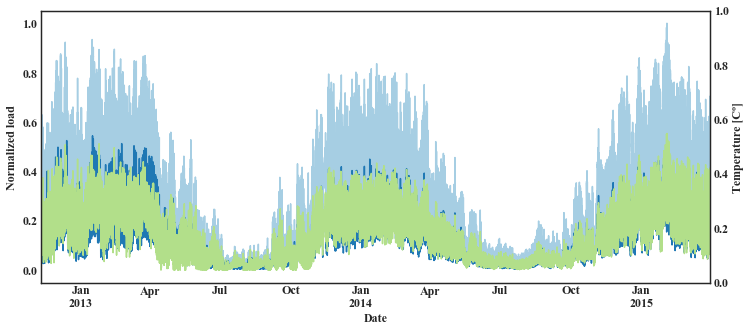

In [23]:
fig, ax = plt.subplots(figsize=(12, 5))
ax2=ax.twinx()

HP["HP"].plot(ax=ax)
HP["ASHP"]["Ehp"].plot(ax=ax)
HP["GSHP"]["Ehp"].plot(ax=ax)
# df["Temperature"].plot(ax=ax2, color='black')
ax.set_ylabel("Normalized load")
ax2.set_ylabel("Temperature [Cº]")
ax.margins(0, None)
plt.savefig(path_save+"HP_original_norm."+fig_format, bbox_inches='tight', format=fig_format, dpi=1000) 

In [24]:
ASHP=ASHP.join(temperature)
ASHP["Temperature"].fillna(method="ffill", inplace=True)
ASHP.reset_index(drop=True,inplace=True)

In [25]:
ASHP["Year"]=[int(x.split('-')[0]) for x in ASHP["Date"]]
temperature["Year"]=temperature.index.year

In [26]:
bins=[0, 5, 10, 15, 20, 25]
group_names=["0-5", "5-10", "10-15", "15-20", "20-25"]
temperature["Temperature cat"]=pd.cut(temperature["Temperature"], bins, labels=group_names)

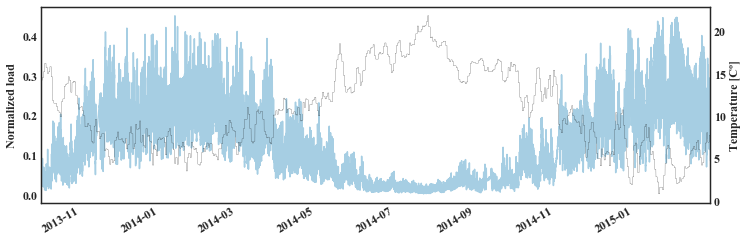

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))
ax2=ax.twinx()
df=ASHP.copy()
df["Date"] = pd.to_datetime(df["Date"]+ " "+df["Hour"].map(str)+":"+ df["HH"].map(str) , format="%Y%m%d %H:%M")
df.set_index("Date", inplace=True)
df["Ehp"].plot(ax=ax)
df["Temperature"].plot(ax=ax2, color='black', linewidth=0.2)

ax.xaxis.label.set_visible(False)
ax.set_ylabel("Normalized load")
ax2.set_ylabel("Temperature [Cº]")

ax.margins(0, None)
plt.savefig(path_save+"ASHP_original_norm."+fig_format, bbox_inches='tight',format=fig_format, dpi=1000) 

In [28]:
# X=np.array(temp["Temperature"]).reshape(-1, 1)
# y=np.array(temp["Total"]).reshape(-1, 1)

In [29]:
# from sklearn.linear_model import Ridge
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import make_pipeline
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score

# for degree in range(1, 5, 1):
#     model = make_pipeline(PolynomialFeatures(degree), Ridge())
#     model.fit(X, y)
#     y_2 = model.predict(X)
#     RMSE=np.sqrt(mean_squared_error(y, y_2))
#     R2=r2_score(y, y_2)
#     print(degree, RMSE, R2)

In [30]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

def getMEF(x, y):
    # # Create linear regression object
    regr = linear_model.LinearRegression()
    
    # # Train the model using the training sets
    regr.fit(x.reshape(-1,1), y.reshape(-1,1))
    y_predict = regr.predict(x.reshape(-1,1))

    # The coefficients
    MEF=regr.coef_[0][0]
    # The mean squared error: the best value is 0.0
    RMSE=mean_squared_error(y.reshape(-1,1), y_predict)
    print(regr.intercept_)
    return regr, RMSE



## Description of the function
get the average profile for each temperature categorie as well as the mean temperature associated, 
apply the relevant profile to the test dataset

In [31]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


def getmodel(X, y):
    y_2=[]
    RMSE_prev=100
    R2_prev=100
    for degree in range(1, 8, 1):
        model = make_pipeline(PolynomialFeatures(degree), Ridge())
        model.fit(X, y)
        y_2 = model.predict(X)
        RMSE=np.sqrt(mean_squared_error(y, y_2))
        R2=r2_score(y, y_2)
        
        print("RMSE=",RMSE, "R2=", R2)
        print((RMSE_prev-RMSE)/RMSE*100)
        print((R2-R2_prev)/R2*100)
        if R2>R2_prev or RMSE<RMSE_prev:
            if (RMSE_prev-RMSE)/RMSE*100<1 and (R2-R2_prev)/R2*100<1:
                return model, degree
        R2_prev=R2
        RMSE_prev=RMSE
    return model



In [32]:
def getmeanprofiles(train_df):
    col=['blue', 'green']
    col=sns.color_palette("Set2", 10)
#     fig, ax = plt.subplots(figsize=(14,5))
    count=0
    mean_HP_profiles={}
    mean_HP_temperatures={}

    for cluster in train_df["Temperature cat"].unique():
        mean_profile=train_df.loc[train_df["Temperature cat"]==cluster, "0": "47"].mean(axis=0).values
        mean_profile_temp=train_df.loc[train_df["Temperature cat"]==cluster, "Temperature"].mean()
#         train_df.loc[train_df["Temperature cat"]==cluster, "0": "47"].mean(axis=0).plot(ax=ax, c=col[count])
        mean_HP_profiles[cluster]=mean_profile
        mean_HP_temperatures[cluster]=mean_profile_temp
        count=count+1

#     lines, labels = ax.get_legend_handles_labels()
#     labels=train_df["Temperature cat"].unique()
#     lgd = ax.legend(lines, labels, title="Legend", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.savefig(path_save+"mean_profile.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
#     plt.show()
#     plt.close(fig)
    
    return mean_HP_profiles, mean_HP_temperatures, 
   
def getsynthesizedprofiles(test_df, models, profiles, temperatures, fit_bool):
    x=[str(x) for x in range(0,48,1)]
    frames=[]
    RMSE=0
    R2=0
    for row in test_df.iterrows():
        profile=profiles[row[1]["Temperature cat"]]
        temperature_value= row[1]["Temperature"]
        if temperature_value>20: #DHW consumption
            model=models[2]
        elif temperature_value<5:
            model=models[1]
        else:
            model=models[0]         
        frames.append(profile*model.predict(temperature_value).ravel()[0]/model.predict(temperatures[row[1]["Temperature cat"]]).ravel()[0])

    HP_df=pd.DataFrame(frames, columns=x).stack().reset_index()
    HP_df.drop(["level_0", "level_1"], axis=1, inplace=True)
    HP_df.columns=["Pred"]
    if not fit_bool:
        HP_df["Org"]=test_df.loc[:,"0":"47"].stack().values
        RMSE=math.sqrt(mean_squared_error(HP_df["Org"].values, HP_df["Pred"].values))
        R2= r2_score(HP_df["Org"].values, HP_df["Pred"].values)     


#         corr = np.cov(df["ASHP"].values, df["ASHP pred"].values)[0][1]/(df["ASHP"].std()*df["ASHP pred"].std())
        
    return HP_df, RMSE, R2

# Test and train ASHP

In [33]:
temp_ASHP=ASHP.reset_index(drop=True)
temp_ASHP=temp_ASHP.groupby(["Date", "HH"]).mean()["Ehp"].unstack("HH")
temp_ASHP.columns = [str(x) for x in temp_ASHP.columns]
temp_ASHP=temp_ASHP.join(temperature)
temp_ASHP["Total"]=temp_ASHP.loc[:, "0":"47"].sum(axis=1)

## Get pictures of daily profiles for ASHP

In [34]:
fig, ax = plt.subplots(figsize=(12, 5))
temp_ASHP.loc[:, '0':'47'].T.plot(ax=ax)
ax.legend_.remove()
ax.set_ylabel("Normalized load")
ax.set_xlabel("Half-hourly time steps")
ax.margins(0, None)
plt.ioff()
plt.savefig(path_save+"ASHP_daily_profiles."+fig_format, bbox_inches='tight', format=fig_format, dpi=1000) 
plt.close(fig)
plt.ion()

## Calculate the regression model linking consumption and temperature

In [35]:
temp= temp_ASHP.sort_values("Temperature", ascending=True).copy()
X=np.array(temp["Temperature"]).reshape(-1, 1)
y=np.array(temp["Total"]).reshape(-1, 1)
regr_5,RMSE=getMEF(temp.loc[temp["Temperature"]<=5,"Temperature"].values, temp.loc[temp["Temperature"]<=5,"Total"].values )
regr_20,RMSE=getMEF(temp.loc[temp["Temperature"]>=20,"Temperature"].values, temp.loc[temp["Temperature"]>=20,"Total"].values )
poly, degree=getmodel(X, y)
print(degree)
models_ASHP=[poly, regr_5, regr_20]

[ 16.31415209]
[ 2.06014687]
RMSE= 1.13761317193 R2= 0.931035439664
8690.33422497
-10640.7297016
RMSE= 0.927817467927 R2= 0.954126504153
22.6117432852
2.42012609322
RMSE= 0.838430834418 R2= 0.9625397017
10.6611815596
0.87406239269
RMSE= 0.823768470215 R2= 0.963838446576
1.77991325645
0.134747154026
RMSE= 0.822344038014 R2= 0.96396339709
0.173216091393
0.0129621637081
5


In [36]:
## display regression model

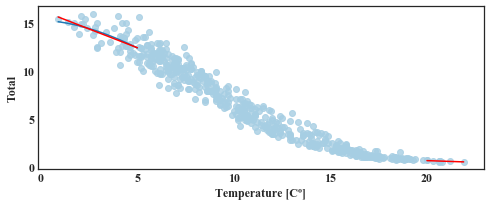

In [37]:
fig, ax = plt.subplots(figsize=(8,3))
sns.regplot(x=temp["Temperature"], y=temp["Total"], fit_reg=False, ax=ax, label="half-hourly")
x_5=temp.loc[temp["Temperature"]<=5,"Temperature"].values
y_5 = regr_5.predict(x_5.reshape(-1,1))
x_20=temp.loc[temp["Temperature"]>=20,"Temperature"].values
y_20 = regr_20.predict(x_20.reshape(-1,1))
x_poly_5=temp.loc[temp["Temperature"]<=5,"Temperature"].values.reshape(-1, 1)
y_poly_5=poly.predict(x_poly_5)
x_poly_20=temp.loc[temp["Temperature"]>=20,"Temperature"].values.reshape(-1, 1)
y_poly_20=poly.predict(x_poly_20)
ax.set_ylabel("Total")
ax.set_xlabel("Temperature [Cº]")
plt.plot(x_poly_5, y_poly_5)
plt.plot(x_5, y_5, color='red')
plt.plot(x_20, y_20, color='red')

plt.savefig(path_save+"Regression_ASHP."+fig_format, bbox_inches='tight', format=fig_format, dpi=1000) 

In [38]:
(1.05421603611-1.05234258161)/1.05421603611
(0.11465378663-0.0313640774049)/0.11465378663

0.7264453418698222

In [39]:
y_org_5=temp.loc[temp["Temperature"]<=5,"Total"].values.reshape(-1, 1)
RMSE=np.sqrt(mean_squared_error(y_org_5, y_poly_5))
R2 = r2_score(y_org_5, y_poly_5)
print("poly", RMSE, R2)
RMSE=np.sqrt(mean_squared_error(y_org_5, y_5))
R2 = r2_score(y_org_5, y_5)
print("linear", RMSE, R2)

poly 1.05421603611 0.392128048824
linear 1.05234258161 0.394286635874


In [40]:
y_org_20=temp.loc[temp["Temperature"]>=20,"Total"].values.reshape(-1, 1)
RMSE=np.sqrt(mean_squared_error(y_org_20, y_poly_20))
R2 = r2_score(y_org_20, y_poly_20)
print("poly", RMSE, R2)
RMSE=np.sqrt(mean_squared_error(y_org_20, y_20))
R2 = r2_score(y_org_20, y_20)
print("linear", RMSE, R2)

poly 0.114653786639 -4.55779573829
linear 0.0313640774049 0.584098190236


In [41]:
# fig, ax = plt.subplots(figsize=(7,5))
# factor=8/temp["Total"].mean()
# sns.regplot(x=temp["Temperature"], y=temp["Total"]*factor, fit_reg=False, ax=ax, label="half-hourly")
# x_5=temp.loc[temp["Temperature"]<=5,"Temperature"].values
# y_5 = regr_5.predict(x_5.reshape(-1,1))*factor
# x_20=temp.loc[temp["Temperature"]>=20,"Temperature"].values
# y_20 = regr_20.predict(x_20.reshape(-1,1))*factor
# x_poly=temp.loc[:,"Temperature"].values.reshape(-1, 1)
# y_poly=poly.predict(x_poly)*factor
# ax.set_ylabel("Daily consumption [kWh]")
# ax.set_xlabel("Temperature [Cº]")
# plt.plot(x_poly, y_poly)
# plt.plot(x_5, y_5, color='red')
# plt.plot(x_20, y_20, color='red')

# plt.savefig(path_save+"Regression_ASHP_denormalized."+fig_format, bbox_inches='tight',format=fig_format, dpi=1000) 

In [42]:
# x_poly=temp.loc[:,"Temperature"].values.reshape(-1, 1)
# y_poly=poly.predict(x_poly)
# RMSE=np.sqrt(mean_squared_error(y, y_poly))
# R2 = r2_score(y, y_poly)
# # len(y_all)
# print(RMSE, R2)
# y_all=np.concatenate((y_5.ravel(),y_poly.ravel(), y_20.ravel()), axis=0)
# RMSE=np.sqrt(mean_squared_error(y, y_all))
# R2 = r2_score(y, y_all)
# len(y_all)
# print(RMSE, R2)

## Change point regression for ASHP

In [43]:
import sys
sys.path.append(computer_path + "/05 - Python/01 - Packages")
import Classes.regression as regression

model = regression.Regression()
model._model(temp_ASHP[["Total", "Temperature"]].copy(), normalize=False,verbose_eval=False)
params= model.param

Regression
update 3


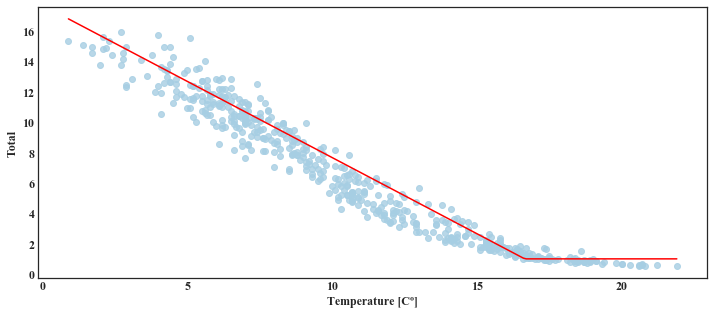

6.33150886255 -1.13624562461


In [44]:
params
beta2=params[1]
beta1=params[0]
beta3=params[2]
x=temp_ASHP.loc[:,"Temperature"].sort_values(ascending=True)
Y_predict= [beta1+beta2*(x-beta3) if x<beta3 else beta1 for x in x]
RMSE=np.sqrt(mean_squared_error(temp_ASHP.loc[:,"Total"].values, Y_predict))
R2=r2_score(temp_ASHP.loc[:,"Total"].values, Y_predict)
fig, ax = plt.subplots(figsize=(12, 5))
sns.regplot(x=temp_ASHP["Temperature"], y=temp_ASHP["Total"], fit_reg=False, ax=ax, label="half-hourly")
plt.plot(x, Y_predict, color='red')
ax.set_xlabel("Temperature [Cº]")
plt.savefig(path_save+"Change_point_Regression_ASHP."+fig_format, bbox_inches='tight' ,format=fig_format, dpi=1000) 
plt.show()
plt.close(fig)
print(RMSE, R2)

In [45]:
temp_ASHP.loc[temp_ASHP["Temperature cat"]=="5-10", :].shape

(202, 52)

In [46]:
## Test and train the model on existing data

In [47]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
for k, (train_index, test_index) in enumerate(kf.split(temp_ASHP)):
    train= temp_ASHP.iloc[train_index]
    test=temp_ASHP.iloc[test_index]
    HP_profiles, HP_temperatures = getmeanprofiles(train)
    df, RMSE_train, R2_train = getsynthesizedprofiles(train,models_ASHP,  HP_profiles, HP_temperatures, False)
    df, RMSE, R2 = getsynthesizedprofiles(test,models_ASHP,  HP_profiles, HP_temperatures, False)
    print(RMSE_train, RMSE, R2_train, R2)
    print((RMSE_train-RMSE)/RMSE*100)

0.026849344457234987 0.025578321857293623 0.92958932377 0.931065063702
4.9691399108692265
0.02635567996396554 0.027414715300396207 0.930749359176 0.926939708679
-3.863017816622602
0.026532493854559292 0.027086609865909172 0.929978210165 0.928121620595
-2.045719320701268
0.026500767590259332 0.027227618896468825 0.930760963713 0.924865432524
-2.6695368000165387
0.02652156686358061 0.026727269362062846 0.929461118519 0.932241345958
-0.769635295307101


In [48]:
## Use the model to estimate consumption in 2016

In [49]:
HP_profiles, HP_temperatures = getmeanprofiles(temp_ASHP)
Profiles_2016, RMSE, R2=getsynthesizedprofiles(temperature.loc[temperature["Year"]==2016, :], models_ASHP,  HP_profiles, HP_temperatures, True)
start=pd.to_datetime('20160101-0000', format='%Y%m%d-%H%M%', errors='ignore')
end=pd.to_datetime('20161231-2330', format='%Y%m%d-%H%M%', errors='ignore')
Profiles_2016["Date"] = pd.date_range(start=start, end=end, freq='30min')
Profiles_2016.set_index("Date", inplace=True)

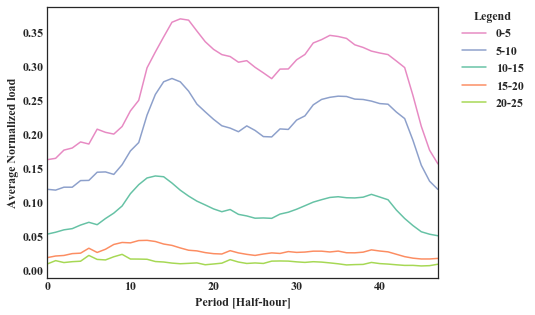

In [50]:
col=sns.color_palette("Set2", 10)
fig, ax = plt.subplots(figsize=(7, 5))
count=0
x=[val for val in range(0, 48,1)]
new_labels=[]
for key, value in HP_profiles.items():
    plt.plot(x, value, color=col[count], label=key)
    count=count+1

ax.set_ylabel("Average Normalized load")
ax.set_xlabel("Period [Half-hour]")  
lines, labels = ax.get_legend_handles_labels()
ax.margins(0,None)

new_labels=['0-5', '5-10', '10-15', '15-20', '20-25']
new_lines=[]
for lab in new_labels:
    for lab_old, line in zip(labels, lines):
        if lab_old == lab:
            new_lines.append(line)

lgd = ax.legend(new_lines, new_labels, title="Legend", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(path_save+"ASHP_profile."+fig_format,  bbox_extra_artists=(lgd,), bbox_inches='tight', format=fig_format, dpi=1000) 
plt.show()

In [51]:

new_lines

In [52]:
Profiles_2016=Profiles_2016.join(temperature)
Profiles_2016.fillna(method='ffill', inplace=True)
Profiles_2016.head()

,Pred,Temperature,Year,Temperature cat
Date,,,,
2016-01-01 00:00:00,0.132512,6.4,2016.0,5-10
2016-01-01 00:30:00,0.131215,6.4,2016.0,5-10
2016-01-01 01:00:00,0.135956,6.4,2016.0,5-10
2016-01-01 01:30:00,0.135936,6.4,2016.0,5-10
2016-01-01 02:00:00,0.146710,6.4,2016.0,5-10


In [53]:
## Display result

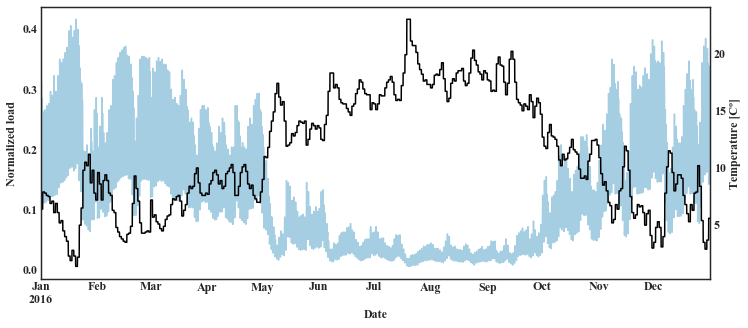

In [54]:
fig, ax = plt.subplots(figsize=(12, 5))
ax2=ax.twinx()
Profiles_2016["Pred"].plot(ax=ax)
Profiles_2016["Temperature"].plot(ax=ax2, color='black')
ax.set_ylabel("Normalized load")
ax2.set_ylabel("Temperature [Cº]")
ax.margins(0, None)
plt.savefig(path_save+"ASHP_2016_norm."+fig_format, bbox_inches='tight',format=fig_format, dpi=1000) 

## Test and train GSHP

In [55]:
temp_GSHP=GSHP.reset_index(drop=True)
temp_GSHP=temp_GSHP.groupby(["Date", "HH"]).mean()["Ehp"].unstack("HH")
temp_GSHP.columns = [str(x) for x in temp_GSHP.columns]
temp_GSHP=temp_GSHP.join(temperature)
temp_GSHP["Total"]=temp_GSHP.loc[:, "0":"47"].sum(axis=1)

In [56]:
temp= temp_GSHP.sort_values("Temperature", ascending=True).copy()
X=np.array(temp["Temperature"]).reshape(-1, 1)
y=np.array(temp["Total"]).reshape(-1, 1)
regr_5,RMSE=getMEF(temp.loc[temp["Temperature"]<=5,"Temperature"].values, temp.loc[temp["Temperature"]<=5,"Total"].values )
regr_20,RMSE=getMEF(temp.loc[temp["Temperature"]>=20,"Temperature"].values, temp.loc[temp["Temperature"]>=20,"Total"].values )
poly, degree=getmodel(X, y)
models_GSHP=[poly, regr_5, regr_20]

[ 16.25661372]
[ 2.35665645]
RMSE= 1.23032188699 R2= 0.928687519648
8027.95424167
-10667.8845558
RMSE= 1.10364308786 R2= 0.942616724141
11.4782397072
1.47771667282
RMSE= 0.919797949433 R2= 0.960142237396
19.9875568908
1.82530385316
RMSE= 0.900909969226 R2= 0.961762382237
2.09654469944
0.168455833831
RMSE= 0.894756094593 R2= 0.962282979956
0.687771189313
0.0541002730706


Regression
update 3
STARTING POINT RMSE: 4.6161431727 equation: Y= 7.299515595987241 + -0.944570653441 * (T- 0.9 )
step:  1 RMSE: 4.98472839813 equation: Y= 5.31591722376 + -0.944570653441 * (T- 3.0 )
step:  2 RMSE: 5.86315586414 equation: Y= 3.33231885154 + -0.944570653441 * (T- 5.1 )
step:  3 RMSE: 6.77752409316 equation: Y= 1.34872047931 + -0.944570653441 * (T- 7.2 )
step:  4 RMSE: 6.89788243086 equation: Y= 0 + -0.944570653441 * (T- 9.3 )
step:  5 RMSE: 5.60951597396 equation: Y= 0 + -0.944570653441 * (T- 11.4 )
step:  6 RMSE: 4.12325204613 equation: Y= 0 + -0.944570653441 * (T- 13.5 )
step:  7 RMSE: 2.57690405677 equation: Y= 0 + -0.944570653441 * (T- 15.6 )
step:  8 RMSE: 1.24800361686 equation: Y= 0 + -0.944570653441 * (T- 17.7 )
step:  9 RMSE: 1.77719936196 equation: Y= 0 + -0.944570653441 * (T- 19.8 )
step:  10 RMSE: 3.50965919886 equation: Y= 0 + -0.944570653441 * (T- 21.9 )
STARTING POINT RMSE: 1.74268037333 equation: Y= 4.3282512127 + -1.03053600302 * (T- 13.5 )
step:  1 RM

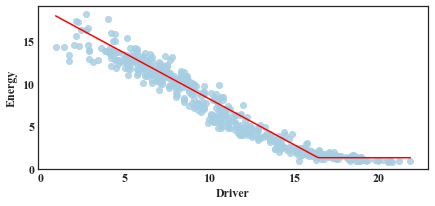

In [57]:
import sys
sys.path.append(computer_path + "/05 - Python/01 - Packages")
import Classes.regression as regression

model = regression.Regression()
model._model(temp_GSHP[["Total", "Temperature"]].copy(), normalize=False,verbose_eval=True)
model._plot()
params= model.param

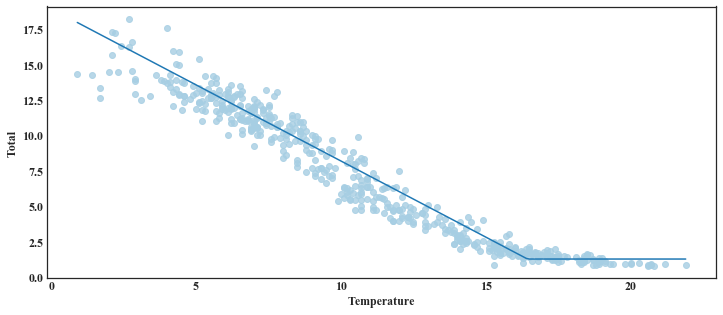

6.64692747115


In [58]:
params
beta2=params[1]
beta1=params[0]
beta3=params[2]
x=temp_GSHP.loc[:,"Temperature"].sort_values(ascending=True)
Y_predict= [beta1+beta2*(x-beta3) if x<beta3 else beta1 for x in x]
RMSE=np.sqrt(mean_squared_error(temp_GSHP.loc[:,"Total"].values, Y_predict))

fig, ax = plt.subplots(figsize=(12,5))
sns.regplot(x=temp_GSHP["Temperature"], y=temp_GSHP["Total"], fit_reg=False, ax=ax, label="half-hourly")
plt.plot(x, Y_predict)
plt.show()
plt.close(fig)
print(RMSE)

In [59]:
# x= np.array([val for val in []])
# fig, ax = plt.subplots(figsize=(12, 5))
# sns.regplot(x=temp_GSHP["Temperature"], y=temp_GSHP["Total"], fit_reg=False, ax=ax, label="half-hourly")
# plt.plot(x, y_2)
# plt.show()
# plt.close(fig)

In [60]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
for k, (train_index, test_index) in enumerate(kf.split(temp_GSHP)):
    train= temp_GSHP.iloc[train_index]
    test=temp_GSHP.iloc[test_index]
    HP_profiles, HP_temperatures = getmeanprofiles(train)
    df, RMSE_train, R2_train =getsynthesizedprofiles(train,models_GSHP,  HP_profiles, HP_temperatures, False)
    df, RMSE, R2 = getsynthesizedprofiles(test,models_GSHP,  HP_profiles, HP_temperatures, False)
    print(RMSE_train, RMSE, R2_train, R2)
    print((RMSE_train-RMSE)/RMSE*100)


0.0325572852080534 0.033318799849235484 0.909505038463 0.894200104613
-2.2855404295108723
0.03263483697899083 0.03323081194147549 0.90683169478 0.904196475862
-1.7934408690773376
0.032602295935742896 0.03361677897605482 0.906187704019 0.905497268397
-3.017787757222483
0.03271498020774702 0.03306304564339322 0.90711780434 0.902835465391
-1.0527325262176896
0.03292368906516011 0.0318942650149035 0.904385656302 0.915086672611
3.2276149012231032


In [61]:
GSHP_profiles, GSHP_temperatures = getmeanprofiles(temp_GSHP)
GSHP_2016, RMSE, R2=getsynthesizedprofiles(temperature.loc[temperature["Year"]==2016, :], models_GSHP,  GSHP_profiles, GSHP_temperatures, True)
start=pd.to_datetime('20160101-0000', format='%Y%m%d-%H%M%', errors='ignore')
end=pd.to_datetime('20161231-2330', format='%Y%m%d-%H%M%', errors='ignore')
GSHP_2016["Date"] = pd.date_range(start=start, end=end, freq='30min')
GSHP_2016.set_index("Date", inplace=True)
GSHP_2016.head()

,Pred
Date,
2016-01-01 00:00:00,0.158577
2016-01-01 00:30:00,0.153345
2016-01-01 01:00:00,0.155655
2016-01-01 01:30:00,0.150999
2016-01-01 02:00:00,0.158459


In [62]:
Profiles_2016.columns= ['Pred ASHP', 'Temperature', 'Year', 'Temperature cat']
Profiles_2016["Pred GSHP"]=GSHP_2016["Pred"]

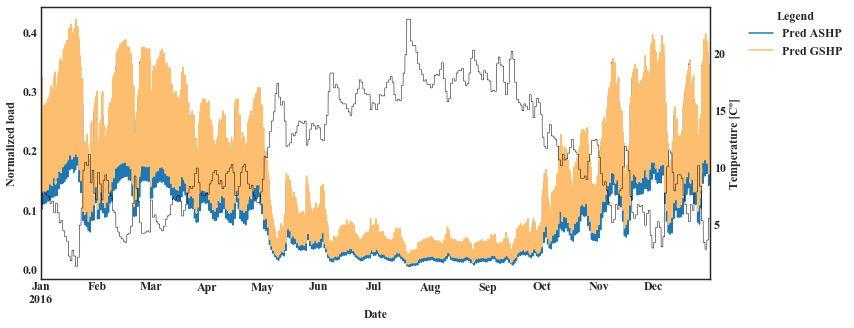

In [63]:
fig, ax = plt.subplots(figsize=(12, 5))
ax2=ax.twinx()
Profiles_2016["Pred ASHP"].plot(ax=ax, c=sns.color_palette()[1])
Profiles_2016["Pred GSHP"].plot(ax=ax, c=sns.color_palette()[6])
Profiles_2016["Temperature"].plot(ax=ax2, color='black', linewidth=0.5)
    
lines, labels = ax.get_legend_handles_labels()
lgd = ax.legend(lines, labels, title="Legend", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel("Normalized load")
ax2.set_ylabel("Temperature [Cº]")
ax.margins(0, None)
plt.savefig(path_save+"ASHP and GSHP."+fig_format, bbox_extra_artists=(lgd,), bbox_inches='tight', format=fig_format, dpi=1000) 

## Test and train Hybrid heat pumps
The concept to model hybrid heat pumps is to cut the peaks, all the peaks from ASHP are estimated to be reduced by 20% 
and ASHP are not consuming when temperature is below 5

In [64]:
HP_profiles, HP_temperatures = getmeanprofiles(temp_ASHP)

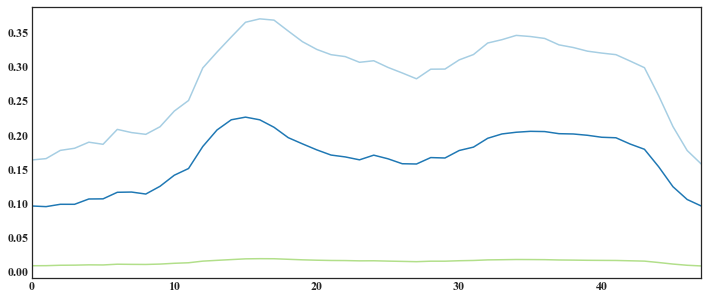

In [65]:
fig, ax = plt.subplots(figsize=(12, 5))

profile=HP_profiles["5-10"] 
profile_5_10=[x*(1-20/100) for x in profile]  
x = [val for val in range(0,48, 1)]

profile=HP_profiles["0-5"] 
profile_0_5=[x*(5/100) for x in profile]
ax.margins(0, None)
plt.plot(x, profile)
plt.plot(x, profile_5_10)
plt.plot(x, profile_0_5)
plt.savefig(path_save+"hybrid heat-pumps."+fig_format, bbox_extra_artists=(lgd,), bbox_inches='tight', format=fig_format, dpi=1000) 

In [66]:
HybridHP_profiles={}

for key, value in HP_profiles.items():
    print(key)
    if key=="5-10":
        HybridHP_profiles[key]=np.array(profile_5_10)
    elif key=="0-5":
        HybridHP_profiles[key]=np.array(profile_0_5)
    else: 
        HybridHP_profiles[key]=value

10-15
15-20
5-10
0-5
20-25


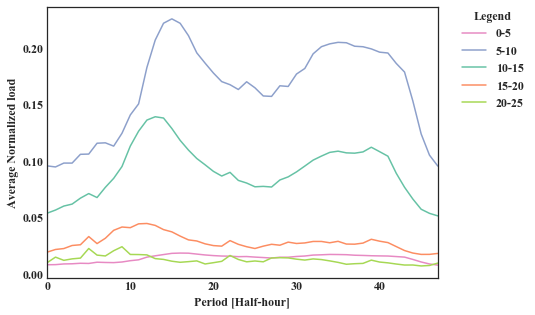

In [67]:
col=sns.color_palette("Set2", 10)
fig, ax = plt.subplots(figsize=(7, 5))
count=0

x=[val for val in range(0, 48,1)]

for key, value in HybridHP_profiles.items():
    plt.plot(x, value, color=col[count], label=key)
    count=count+1

lines, labels = ax.get_legend_handles_labels()
    
new_labels=['0-5', '5-10', '10-15', '15-20', '20-25']
new_lines=[]
for lab in new_labels:
    for lab_old, line in zip(labels, lines):
        if lab_old == lab:
            new_lines.append(line)
            
            
ax.set_ylabel("Average Normalized load")
ax.set_xlabel("Period [Half-hour]")
ax.margins(0,None)
lgd = ax.legend(new_lines, new_labels, title="Legend", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(path_save+"hybrid_HP_profile."+fig_format, bbox_extra_artists=(lgd,), bbox_inches='tight', format=fig_format, dpi=1000) 
plt.show()
plt.close(fig)

In [68]:
HybridHP_2016, RMSE, R2=getsynthesizedprofiles(temperature.loc[temperature["Year"]==2016, :], models_ASHP, HybridHP_profiles, HP_temperatures, True)
start=pd.to_datetime('20160101-0000', format='%Y%m%d-%H%M%', errors='ignore')
end=pd.to_datetime('20161231-2330', format='%Y%m%d-%H%M%', errors='ignore')
HybridHP_2016["Date"] = pd.date_range(start=start, end=end, freq='30min')
HybridHP_2016.set_index("Date", inplace=True)

Profiles_2016["Pred HybridHP"]=HybridHP_2016["Pred"]

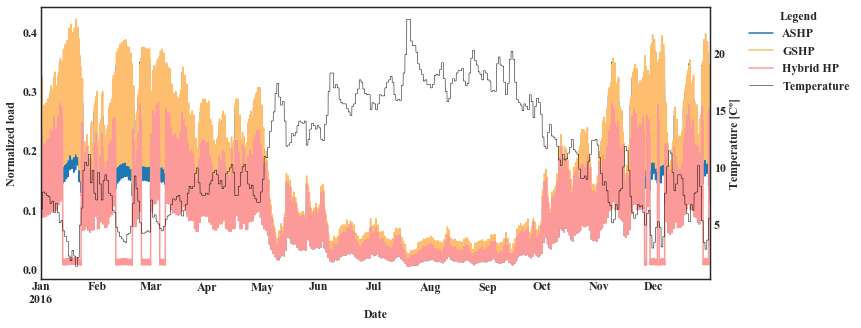

In [69]:
fig, ax = plt.subplots(figsize=(12, 5))
ax2=ax.twinx()
Profiles_2016["Pred ASHP"].plot(ax=ax, c=sns.color_palette()[1], label="ASHP")
Profiles_2016["Pred GSHP"].plot(ax=ax, c=sns.color_palette()[6], label="GSHP")
Profiles_2016["Pred HybridHP"].plot(ax=ax, c=sns.color_palette()[4], label="Hybrid HP")

Profiles_2016["Temperature"].plot(ax=ax2, color='black', linewidth=0.5)
    
lines, labels = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lgd = ax.legend(lines+lines_2, labels+labels_2, title="Legend", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel("Normalized load")
ax2.set_ylabel("Temperature [Cº]")
ax.margins(0, None)
plt.savefig(path_save+"HPs profiles."+fig_format, bbox_extra_artists=(lgd,), bbox_inches='tight', format=fig_format, dpi=1000)

In [70]:
addTimePeriod(temperature)
temperature.head()

,Temperature,Year,Temperature cat,Hour,DayOfWeek_name,DayOfWeek,Day,Month,Month name,Weekday,HH,Date,Week,Season,Season num
Date,,,,,,,,,,,,,,,
2012-11-10,8.7,2012,5-10,0,Saturday,5,315,11,November,0,0,2012-11-10,45,Winter,1
2012-11-11,7.7,2012,5-10,0,Sunday,6,316,11,November,0,1,2012-11-11,45,Winter,1
2012-11-12,8.0,2012,5-10,0,Monday,0,317,11,November,1,2,2012-11-12,46,Winter,1
2012-11-13,10.5,2012,10-15,0,Tuesday,1,318,11,November,1,3,2012-11-13,46,Winter,1
2012-11-14,10.7,2012,10-15,0,Wednesday,2,319,11,November,1,4,2012-11-14,46,Winter,1


In [71]:
## Resistive consumption in the domestic sector

In [72]:
path=computer_path+ r'/04 - Projects/10 - Papers and conferences/02 - ECOS conference/UK data/'
file = "Heat-temperature-2010.csv"
heat_temperature = pd.read_csv(path+file, index_col=0, parse_dates=True)
addTimePeriod(heat_temperature)

In [73]:
heat_temperature=heat_temperature.reset_index(drop=True)
heat_temperature["HeatDemand"]=normalize_serie(heat_temperature["HeatDemand"])
heat_temperature=heat_temperature.groupby(["Date"]).mean()

heat_temperature.columns

Index(['Day', 'Time', 'Temperature', 'HeatDemand', 'Hour', 'DayOfWeek',
       'Month', 'Year', 'Weekday', 'HH', 'Week', 'Season num'],
      dtype='object')

In [74]:
model_resistive = regression.Regression()
model_resistive._model(heat_temperature[["HeatDemand", "Temperature"]].copy(), normalize=False,verbose_eval=False)

Regression
update 3


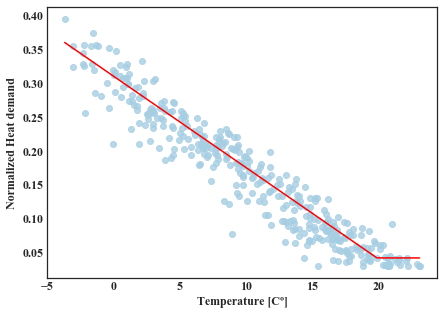

In [75]:
x=heat_temperature.loc[:,"Temperature"].sort_values(ascending=True)
Y_predict= model_resistive.predict(x)

fig, ax = plt.subplots(figsize=(7, 5))
sns.regplot(x=heat_temperature["Temperature"], y=heat_temperature["HeatDemand"], fit_reg=False, ax=ax, label="half-hourly")
plt.plot(x, Y_predict, color='red')
ax.set_ylabel("Normalized Heat demand")
ax.set_xlabel("Temperature [Cº]")

plt.savefig(path_save+"Gas boilers regression."+fig_format, bbox_inches='tight', format=fig_format, dpi=1000) 
plt.show()
plt.close(fig)

In [76]:
path=computer_path+ r'/04 - Projects/01 - Flexis/04 - Data/00 - Profiles/'
file = "Elexon electricity profile classes.xlsx"
profiles = pd.read_excel(path+file, header=[0,1])
profiles.reset_index(inplace=True)
profiles_class2= profiles["Profile Class 2"].T.copy()
profiles_class2.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
Settlement period,,,,,,,,,,,,,,,,,,,,,
Autumn 1,0.351128,0.339481,0.360291,0.705274,0.634624,0.606708,0.583670,0.556183,0.494140,0.491958,...,0.720261,0.705937,0.687359,0.653511,0.624703,0.580475,0.539413,0.478023,0.412377,0.386465
Autumn Sat,0.364305,0.355085,0.380308,0.758932,0.677482,0.658175,0.630080,0.596871,0.507222,0.499544,...,0.682115,0.655706,0.628620,0.595449,0.578182,0.553880,0.510692,0.475640,0.424199,0.394240
Autumn Sun,0.374475,0.378654,0.397095,0.736963,0.662963,0.629817,0.610547,0.575741,0.505881,0.492930,...,0.726327,0.698831,0.684098,0.649315,0.603275,0.562258,0.526412,0.461631,0.399798,0.372938
High Summer 1,0.296645,0.282719,0.277066,0.444601,0.399157,0.365765,0.355606,0.371466,0.341991,0.347404,...,0.539822,0.527447,0.540696,0.522785,0.529510,0.501954,0.475764,0.417156,0.365266,0.325701
High Summer Sat,0.294047,0.293120,0.286575,0.460445,0.403130,0.362419,0.348831,0.366845,0.346332,0.341857,...,0.508940,0.499358,0.509610,0.504165,0.496334,0.470082,0.447442,0.399192,0.373784,0.329983


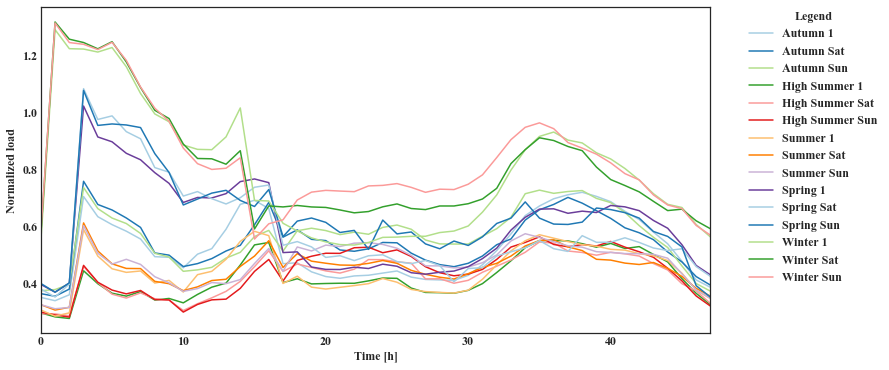

In [77]:
fig, ax = plt.subplots(figsize=(12, 6))
profiles_class2.T.plot(ax=ax)
lines, labels = ax.get_legend_handles_labels()
lgd = ax.legend(lines, labels, title="Legend", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel("Normalized load")
ax.set_xlabel("Time [h]")
ax.margins(0, None)
plt.savefig(path_save+"Elexon profiles class 2."+fig_format, bbox_extra_artists=(lgd,), bbox_inches='tight', format=fig_format, dpi=1000) 

In [78]:
frames=[]
avg_temp_season= temperature.groupby(["Season", "Weekday"]).mean()["Temperature"].reset_index()
avg_temp_season["Key"]=avg_temp_season["Season"]+" "+avg_temp_season["Weekday"].map(str)
avg_temp_season=avg_temp_season.set_index("Key")

for index, row in temperature.loc[temperature["Year"]==2016, :].iterrows():
    temperature_value=row["Temperature"]
    
    key=row["Season"]
    if row["Weekday"]==1:
        key=key+ " "+str(1)
        avg_temperature=avg_temp_season.loc[key, "Temperature"]
    elif row["DayOfWeek_name"]=="Saturday":
        avg_temperature=avg_temp_season.loc[key+" 0", "Temperature"]
        key=key+ " Sat"
        
    else: 
        avg_temperature=avg_temp_season.loc[key+" 0", "Temperature"]
        key=key+ " Sun"
    
    temp_profile=profiles_class2.loc[key, :].values*model_resistive.predict([temperature_value])[0]/model_resistive.predict([avg_temperature])[0]
    frames.append(temp_profile.ravel())

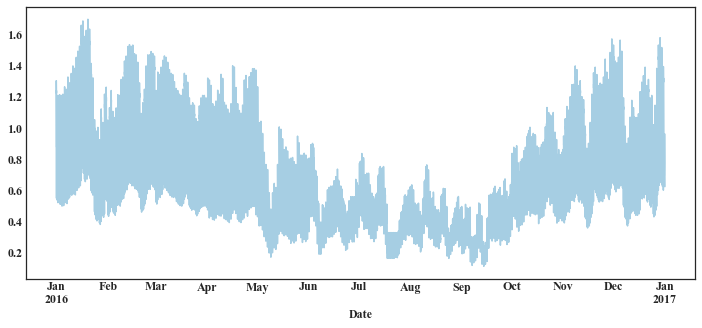

In [79]:
fig, ax = plt.subplots(figsize=(12, 5))
residential_2016=pd.DataFrame()
columns=[str(x) for x in range(0, 48, 1)]
residential_2016["Value"]=pd.DataFrame(frames, columns=columns).values.ravel()

start=pd.to_datetime('20160101-0000', format='%Y%m%d-%H%M%', errors='ignore')
end=pd.to_datetime('20161231-2330', format='%Y%m%d-%H%M%', errors='ignore')
residential_2016["Date"] = pd.date_range(start=start, end=end, freq='30min')
residential_2016.set_index("Date", inplace=True)
residential_2016["Value"].plot(ax=ax)
plt.savefig(path_save+"residential."+fig_format, bbox_extra_artists=(lgd,), bbox_inches='tight',format=fig_format, dpi=1000) 

In [80]:
Profiles_2016["Residential resistive"]=residential_2016["Value"].values

## Commercial sector

In [81]:
commercial_profiles= pd.read_csv(path_save+"Profiles_commercial_sector_heating_hot_water.csv")
commercial_profiles=commercial_profiles.loc[(commercial_profiles["Type"]=="Total") & (commercial_profiles["Season"]=="Average"), :]

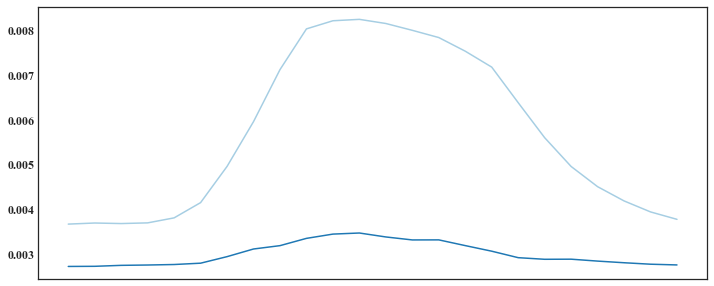

In [82]:
fig, ax = plt.subplots(figsize=(12, 5))
commercial_profiles.loc[:, "0":"23"].T.plot(ax=ax)
ax.legend_.remove()

In [83]:
frames=[]
avg_temperature_weekday=temperature.loc[(temperature["Weekday"]==1), "Temperature"].mean()
avg_temperature_weekend=temperature.loc[temperature["Weekday"]==0, "Temperature"].mean()
for index, row in temperature.loc[temperature["Year"]==2016, :].iterrows():

    temperature_value=row["Temperature"]
  
    profile=[]
    if row["Weekday"]==1:
        avg_temperature=avg_temperature_weekday
        profile=commercial_profiles.loc[commercial_profiles["Weekday"]==1, "0":"23"].values
        
    else: 
        avg_temperature=avg_temperature_weekend
        profile=commercial_profiles.loc[commercial_profiles["Weekday"]==0, "0":"23"].values
        
    temp_profile=profile*model_resistive.predict([temperature_value])[0]/model_resistive.predict([avg_temperature])[0]
    frames.append(temp_profile.ravel())

columns=[str(x) for x in range(0, 24,1)]

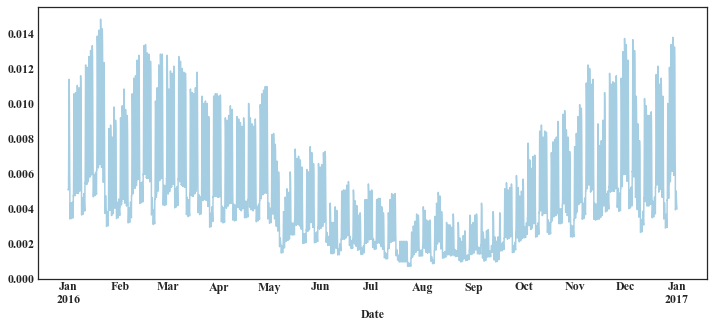

In [84]:
fig, ax = plt.subplots(figsize=(12, 5))
commercial_2016=pd.DataFrame()
commercial_2016["Value"]=pd.DataFrame(frames, columns=columns).values.ravel()

start=pd.to_datetime('20160101-0000', format='%Y%m%d-%H%M%', errors='ignore')
end=pd.to_datetime('20161231-2330', format='%Y%m%d-%H%M%', errors='ignore')
commercial_2016["Date"] = pd.date_range(start=start, end=end, freq='h')
commercial_2016.set_index("Date", inplace=True)
commercial_2016["Value"].plot(ax=ax)
plt.savefig(path_save+"commercial."+fig_format, bbox_extra_artists=(lgd,), bbox_inches='tight' ,format=fig_format, dpi=1000) 

In [85]:
commercial_2016 = commercial_2016.resample('30min').mean()
commercial_2016.interpolate(inplace=True)
Profiles_2016["Commercial"]=normalize_serie(commercial_2016["Value"])

In [86]:
total_demand_2016=pd.read_csv(path_save+"data 2016.csv", index_col=0, parse_dates=True, header=None, names=["Date", "Load UK"])
total_demand_2016.head()

,Load UK
Date,
2016-01-01 00:00:00,27620.000000
2016-01-01 00:30:00,28284.666667
2016-01-01 01:00:00,28527.333333
2016-01-01 01:30:00,27841.000000
2016-01-01 02:00:00,27050.000000


## Scenario 2016

In [87]:
year=2016
Demand=283.7441745*1000#GWh
ASHP_peak_demand= 0.104897442593644*1000 #in MW, Based on a ADMD of 1.7kW
GSHP_peak_demand= 0.035138997*1000 #in MW, Based on a ADMD of 1.7kW
Hybrid_peak_demand = 0.013976251*1000
residential_resistive_consumption=27601*1000 #Electricity consumption from residential sector space heating+ hot water in MWh
commercial_sector_consumption = 11075*1000 #Electricity consumption from commercial sector space heating+ hot water in MWh
industrial_sector_consumption = 7292*1000 #Electricity consumption from industrial sector space heating+ hot water in MWh

In [88]:
Profiles_2016=Profiles_2016.merge(total_demand_2016, how='left', left_index=True, right_index=True)
Profiles_2016["Load UK"]=Profiles_2016["Load UK"].fillna(method='ffill')

In [89]:
print(Profiles_2016["Pred GSHP"].max())
print(Profiles_2016.loc[Profiles_2016["Temperature cat"]=="5-10", "Pred HybridHP"].max())
print(Profiles_2016.loc[Profiles_2016["Temperature cat"]=="5-10", "Pred ASHP"].max()*(1-20/100))

0.42209146096
0.282249547192
0.282249547192


In [90]:
Profiles_2016["ASHP 2016"]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()

In [91]:
Profiles_2016["ASHP 2016"]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()
Profiles_2016["GSHP 2016"]=Profiles_2016["Pred GSHP"]*GSHP_peak_demand/Profiles_2016["Pred GSHP"].max()
Profiles_2016["HybridHP 2016"]=Profiles_2016["Pred HybridHP"]*Hybrid_peak_demand/Profiles_2016["Pred HybridHP"].max()

In [92]:
Profiles_2016["Load UK"]=Profiles_2016["Load UK"]*Demand/(Profiles_2016["Load UK"].sum()/2)
Profiles_2016["Load UK"].sum()/2

283744.17449999996

In [93]:
Profiles_2016["Residential resistive"]=Profiles_2016["Residential resistive"]*residential_resistive_consumption*2/Profiles_2016["Residential resistive"].sum()

# Profiles_2016["ElecforResidentialHeat"].sum()/2

In [94]:
Profiles_2016["ElecforResidentialHeat"]=Profiles_2016["Residential resistive"]+Profiles_2016["HybridHP 2016"]+Profiles_2016["ASHP 2016"]+Profiles_2016["GSHP 2016"]
Profiles_2016["ElecforResidentialHeat"].sum()/2

28029158.659209888

In [95]:
Profiles_2016["ElecforCommercialHeat"]=Profiles_2016["Commercial"]*commercial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles_2016["ElecforCommercialHeat"].sum()/2

11075000.0

In [96]:
Profiles_2016["ElecforIndustrialHeat"]=Profiles_2016["Commercial"]*industrial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles_2016["ElecforIndustrialHeat"].sum()/2

7292000.0

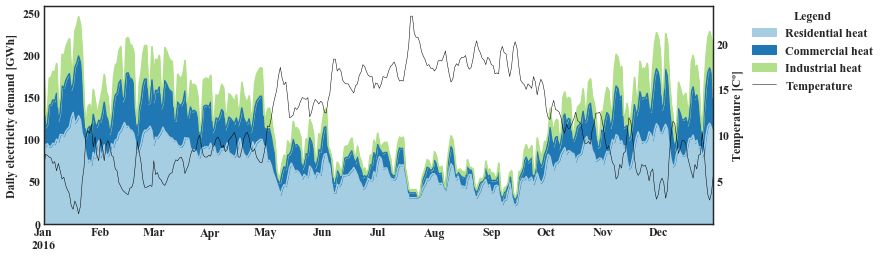

In [97]:
fig, ax = plt.subplots(figsize=(12, 4))
ax2=ax.twinx()
Profiles_2016.loc[: ,["ElecforResidentialHeat", "ElecforCommercialHeat","ElecforIndustrialHeat"]].resample("d").sum().divide(2000).plot.area(ax=ax)
Profiles_2016["Temperature"].resample('d').mean().plot(ax=ax2, color='black', linewidth=0.5)

lines, labels = ax.get_legend_handles_labels()
labels=["Residential heat", "Commercial heat", "Industrial heat"]

lines2, labels2 = ax2.get_legend_handles_labels()

lgd = ax.legend(lines+lines2, labels+labels2, title="Legend", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.xaxis.label.set_visible(False)
ax.set_ylabel("Daily electricity demand [GWh]")
ax2.set_ylabel("Temperature [Cº]")
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))
ax.margins(0, None)
plt.savefig(path_save+"heat_profiles_2016."+fig_format, bbox_extra_artists=(lgd,), bbox_inches='tight',format=fig_format, dpi=1000) 

In [98]:
Profiles_2016.fillna(method='ffill', inplace=True)
Profiles_2016["NH_ElecDemand"]=Profiles_2016["Load UK"]*1000 - (Profiles_2016["ElecforResidentialHeat"]+Profiles_2016["ElecforCommercialHeat"]+Profiles_2016["ElecforIndustrialHeat"])
addTimePeriod(Profiles_2016)
Profiles_2016["Time"]=Profiles_2016["HH"]+1
Profiles_2016.loc[:, ["Day", "Time","ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat", "NH_ElecDemand"]].to_csv(path_save+"EnergyDemand_"+str(year)+".csv")

In [99]:
Profiles_2016.loc[:, ["ASHP 2016","GSHP 2016","HybridHP 2016", "Residential resistive"]].sum()/2/1000000

ASHP 2016                 0.286038
GSHP 2016                 0.104144
HybridHP 2016             0.037977
Residential resistive    27.601000
dtype: float64

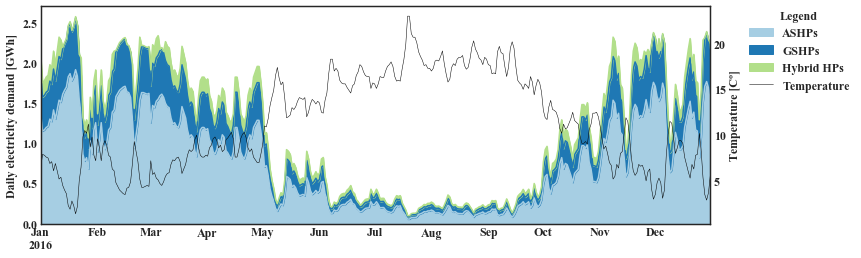

In [100]:
fig, ax = plt.subplots(figsize=(12, 4))
ax2=ax.twinx()

Profiles_2016.loc[:, ["ASHP 2016","GSHP 2016","HybridHP 2016"]].resample('d').sum().divide(2000).plot.area(ax=ax)

Profiles_2016["Temperature"].resample('d').mean().plot(ax=ax2, color='black', linewidth=0.5)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
labels=["ASHPs", "GSHPs", "Hybrid HPs"]
lgd = ax.legend(lines+lines2, labels+labels2, title="Legend", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel("Daily electricity demand [GWh]")
ax2.set_ylabel("Temperature [Cº]")
ax.xaxis.label.set_visible(False)
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:,.1f}'.format(x)))
ax.margins(0, None)
plt.savefig(path_save+"heat_profiles_2016_HPs."+fig_format, bbox_extra_artists=(lgd,), bbox_inches='tight',format=fig_format, dpi=1000)

In [101]:
# Profiles_normalized=


Profiles_2016["Normalized GSHP"]=normalize_serie(Profiles_2016["Pred GSHP"].values)
Profiles_2016["Normalized ASHP"]=normalize_serie(Profiles_2016["Pred ASHP"].values)
Profiles_2016["Normalized HybridHP"]=normalize_serie(Profiles_2016["Pred HybridHP"].values)
Profiles_2016["Normalized Commercial"]=normalize_serie(Profiles_2016["ElecforCommercialHeat"].values)
Profiles_2016["Normalized Industrial"]=normalize_serie(Profiles_2016["ElecforIndustrialHeat"].values)

In [102]:
norm_cols = []
for x in Profiles_2016.columns:
    if "Normalized" in x:
        norm_cols.append(x)
norm_cols

['Normalized GSHP',
 'Normalized ASHP',
 'Normalized HybridHP',
 'Normalized Commercial',
 'Normalized Industrial']

# Profiles 2020

In [103]:
year=2020
Demand=275145 #GWh
ASHP_peak_demand= 0.669*1000 #in MW, Based on a ADMD of 1.7kW
GSHP_peak_demand= 0.067*1000 #in MW, Based on a ADMD of 1.7kW
Hybrid_peak_demand = 0.310*1000
residential_resistive_consumption=26691*1000 #Electricity consumption from residential sector space heating+ hot water in MWh
commercial_sector_consumption = 13546*1000 #Electricity consumption from commercial sector space heating+ hot water in MWh
industrial_sector_consumption = 7209*1000 #Electricity consumption from industrial sector space heating+ hot water in MWh

In [104]:
Profiles=Profiles_2016[["Temperature", "Temperature cat", "Day", "Time"]].copy()

In [105]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()

In [106]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()
Profiles["GSHP "+str(year)]=Profiles_2016["Pred GSHP"]*GSHP_peak_demand/Profiles_2016["Pred GSHP"].max()
# Hybrid_peak_demand = Profiles.loc[Profiles["Temperature cat"]=="5-10", "ASHP "+str(year)].max()*(1-20/100)
Profiles["HybridHP "+str(year)]=Profiles_2016["Pred HybridHP"]*Hybrid_peak_demand/Profiles_2016["Pred HybridHP"].max()

In [107]:
Profiles["ElecforResidentialHeat"]=Profiles_2016["Residential resistive"]*residential_resistive_consumption*2/Profiles_2016["Residential resistive"].sum()
Profiles["ElecforResidentialHeat"]=Profiles["ElecforResidentialHeat"]+Profiles["HybridHP "+str(year)]+Profiles["ASHP "+str(year)]+Profiles["GSHP "+str(year)]
Profiles["ElecforCommercialHeat"]=Profiles_2016["Commercial"]*commercial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["ElecforIndustrialHeat"]=Profiles_2016["Commercial"]*industrial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["Load UK"]=Profiles_2016["Load UK"]*Demand/(Profiles_2016["Load UK"].sum()/2)
Profiles["NH_ElecDemand"]=Profiles["Load UK"]*1000 - (Profiles["ElecforResidentialHeat"]+Profiles["ElecforCommercialHeat"]+Profiles["ElecforIndustrialHeat"])

In [108]:
Profiles.loc[:, ["Day", "Time","ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat", "NH_ElecDemand"]].to_csv(path_save+"EnergyDemand_"+str(year)+".csv")

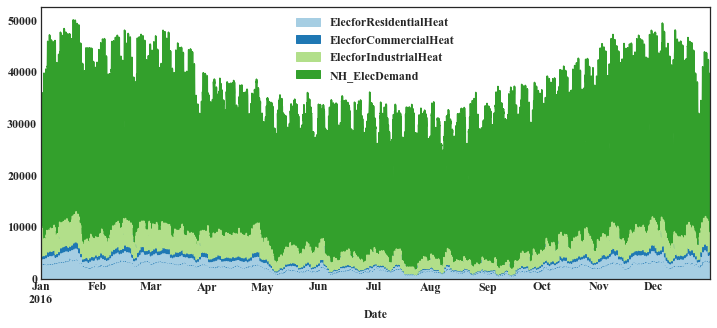

In [109]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.margins(0, None)
Profiles.loc[:, ["ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat", "NH_ElecDemand"]].plot.area(ax=ax)

In [110]:
Profiles.loc[:, ["ASHP "+str(year), "GSHP "+str(year),"HybridHP "+str(year)]].sum()/2/1000000

ASHP 2020        1.824254
GSHP 2020        0.198573
HybridHP 2020    0.842338
dtype: float64

# Profiles 2025

In [111]:
year=2025
Demand=291374 #GWh
ASHP_peak_demand= 3.41178*1000 #in MW, Based on a ADMD of 1.7kW
GSHP_peak_demand= 0.1085*1000 #in MW, Based on a ADMD of 1.7kW
Hybrid_peak_demand = 1.1480*1000
residential_resistive_consumption=27157*1000 #Electricity consumption from residential sector space heating+ hot water in MWh
commercial_sector_consumption = 17880*1000 #Electricity consumption from commercial sector space heating+ hot water in MWh
industrial_sector_consumption = 7498*1000 #Electricity consumption from industrial sector space heating+ hot water in MWh

In [112]:
Profiles=Profiles_2016[["Temperature", "Temperature cat", "Day", "Time"]].copy()

In [113]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()

In [114]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()
Profiles["GSHP "+str(year)]=Profiles_2016["Pred GSHP"]*GSHP_peak_demand/Profiles_2016["Pred GSHP"].max()
# Hybrid_peak_demand = Profiles.loc[Profiles["Temperature cat"]=="5-10", "ASHP "+str(year)].max()*(1-20/100)
Profiles["HybridHP "+str(year)]=Profiles_2016["Pred HybridHP"]*Hybrid_peak_demand/Profiles_2016["Pred HybridHP"].max()

In [115]:
Profiles["ElecforResidentialHeat"]=Profiles_2016["Residential resistive"]*residential_resistive_consumption*2/Profiles_2016["Residential resistive"].sum()
Profiles["ElecforResidentialHeat"]=Profiles["ElecforResidentialHeat"]+Profiles["HybridHP "+str(year)]+Profiles["ASHP "+str(year)]+Profiles["GSHP "+str(year)]
Profiles["ElecforCommercialHeat"]=Profiles_2016["Commercial"]*commercial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["ElecforIndustrialHeat"]=Profiles_2016["Commercial"]*industrial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["Load UK"]=Profiles_2016["Load UK"]*Demand/(Profiles_2016["Load UK"].sum()/2)
Profiles["NH_ElecDemand"]=Profiles["Load UK"]*1000 - (Profiles["ElecforResidentialHeat"]+Profiles["ElecforCommercialHeat"]+Profiles["ElecforIndustrialHeat"])

In [116]:
Profiles.loc[:, ["Day", "Time","ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat", "NH_ElecDemand"]].to_csv(path_save+"EnergyDemand_"+str(year)+".csv")

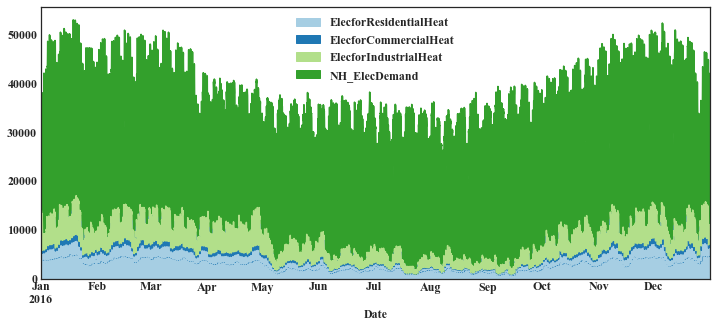

In [117]:
fig, ax = plt.subplots(figsize=(12,5))
ax.margins(0, None)
Profiles.loc[:, ["ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat", "NH_ElecDemand"]].plot.area(ax=ax)

In [118]:
Profiles.loc[:, ["ASHP "+str(year), "GSHP "+str(year),"HybridHP "+str(year)]].sum()/2/1000000

ASHP 2025        9.303366
GSHP 2025        0.321569
HybridHP 2025    3.119368
dtype: float64

# Profiles 2030

In [119]:
year=2030
Demand=295.032*1000 #GWh
ASHP_peak_demand= 6.078804677*1000 #in MW, Based on a ADMD of 1.7kW
GSHP_peak_demand= 0.286540503*1000 #in MW, Based on a ADMD of 1.7kW
Hybrid_peak_demand = 2.441250643*1000
residential_resistive_consumption=29811*1000 #Electricity consumption from residential sector space heating+ hot water in MWh
commercial_sector_consumption = 26083*1000 #Electricity consumption from commercial sector space heating+ hot water in MWh
industrial_sector_consumption = 7683*1000 #Electricity consumption from industrial sector space heating+ hot water in MWh

In [120]:
Profiles=Profiles_2016[["Temperature", "Temperature cat", "Day", "Time"]].copy()

In [121]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()

In [122]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()
Profiles["GSHP "+str(year)]=Profiles_2016["Pred GSHP"]*GSHP_peak_demand/Profiles_2016["Pred GSHP"].max()
# Hybrid_peak_demand = Profiles.loc[Profiles["Temperature cat"]=="5-10", "ASHP "+str(year)].max()*(1-20/100)
Profiles["HybridHP "+str(year)]=Profiles_2016["Pred HybridHP"]*Hybrid_peak_demand/Profiles_2016["Pred HybridHP"].max()

In [123]:
Profiles["ElecforResidentialHeat"]=Profiles_2016["Residential resistive"]*residential_resistive_consumption*2/Profiles_2016["Residential resistive"].sum()
Profiles["ElecforResidentialHeat"]=Profiles["ElecforResidentialHeat"]+Profiles["HybridHP "+str(year)]+Profiles["ASHP "+str(year)]+Profiles["GSHP "+str(year)]
Profiles["ElecforCommercialHeat"]=Profiles_2016["Commercial"]*commercial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["ElecforIndustrialHeat"]=Profiles_2016["Commercial"]*industrial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["Load UK"]=Profiles_2016["Load UK"]*Demand/(Profiles_2016["Load UK"].sum()/2)
Profiles["NH_ElecDemand"]=Profiles["Load UK"]*1000 - (Profiles["ElecforResidentialHeat"]+Profiles["ElecforCommercialHeat"]+Profiles["ElecforIndustrialHeat"])

In [124]:
Profiles.loc[:, ["Day", "Time","ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat", "NH_ElecDemand"]].to_csv(path_save+"EnergyDemand_"+str(year)+".csv")

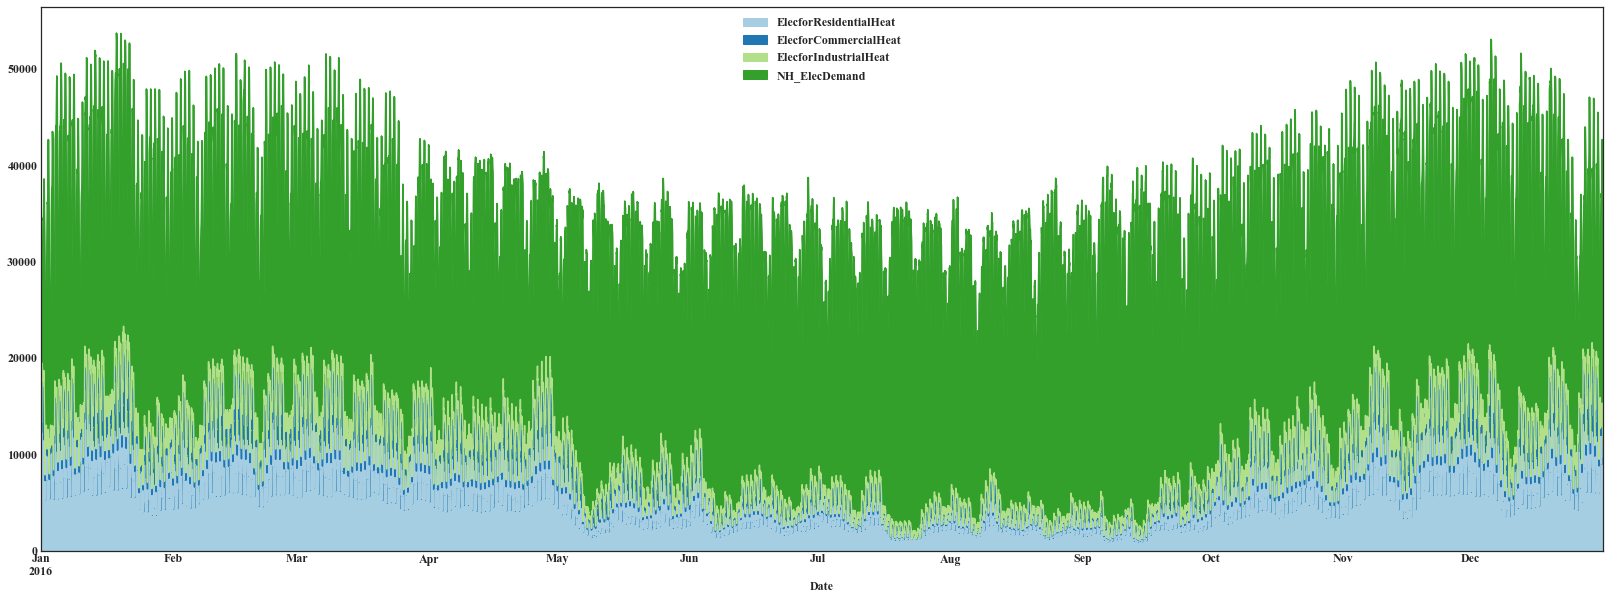

In [125]:
fig, ax = plt.subplots(figsize=(28, 10))
ax.margins(0, None)
Profiles.loc[:, ["ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat", "NH_ElecDemand"]].plot.area(ax=ax)

In [126]:
Profiles.loc[:, ["ASHP "+str(year), "GSHP "+str(year),"HybridHP "+str(year)]].sum()/2/1000000

ASHP 2030        16.575906
GSHP 2030         0.849241
HybridHP 2030     6.633413
dtype: float64

# Profiles 2020 Steady state

In [127]:
year=2020
Demand=279.216*1000 #GWh
ASHP_peak_demand= 0.3505*1000 #in MW, Based on a ADMD of 1.7kW
GSHP_peak_demand= 0.0498*1000 #in MW, Based on a ADMD of 1.7kW
Hybrid_peak_demand = 0.02967*1000
residential_resistive_consumption=29749*1000 #Electricity consumption from residential sector space heating+ hot water in MWh
commercial_sector_consumption = 11664*1000 #Electricity consumption from commercial sector space heating+ hot water in MWh
industrial_sector_consumption = 7078*1000 #Electricity consumption from industrial sector space heating+ hot water in MWh

In [128]:
Profiles=Profiles_2016[["Temperature", "Temperature cat", "Day", "Time"]].copy()

In [129]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()

In [130]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()
Profiles["GSHP "+str(year)]=Profiles_2016["Pred GSHP"]*GSHP_peak_demand/Profiles_2016["Pred GSHP"].max()
# Hybrid_peak_demand = Profiles.loc[Profiles["Temperature cat"]=="5-10", "ASHP "+str(year)].max()*(1-20/100)
Profiles["HybridHP "+str(year)]=Profiles_2016["Pred HybridHP"]*Hybrid_peak_demand/Profiles_2016["Pred HybridHP"].max()

In [131]:
Profiles["ElecforResidentialHeat"]=Profiles_2016["Residential resistive"]*residential_resistive_consumption*2/Profiles_2016["Residential resistive"].sum()
Profiles["ElecforResidentialHeat"]=Profiles["ElecforResidentialHeat"]+Profiles["HybridHP "+str(year)]+Profiles["ASHP "+str(year)]+Profiles["GSHP "+str(year)]
Profiles["ElecforCommercialHeat"]=Profiles_2016["Commercial"]*commercial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["ElecforIndustrialHeat"]=Profiles_2016["Commercial"]*industrial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["Load UK"]=Profiles_2016["Load UK"]*Demand/(Profiles_2016["Load UK"].sum()/2)
Profiles["NH_ElecDemand"]=Profiles["Load UK"]*1000 - (Profiles["ElecforResidentialHeat"]+Profiles["ElecforCommercialHeat"]+Profiles["ElecforIndustrialHeat"])

In [132]:
Profiles.loc[:, ["Day", "Time","ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat", "NH_ElecDemand"]].to_csv(path_save+"EnergyDemand_steadystate_"+str(year)+".csv")

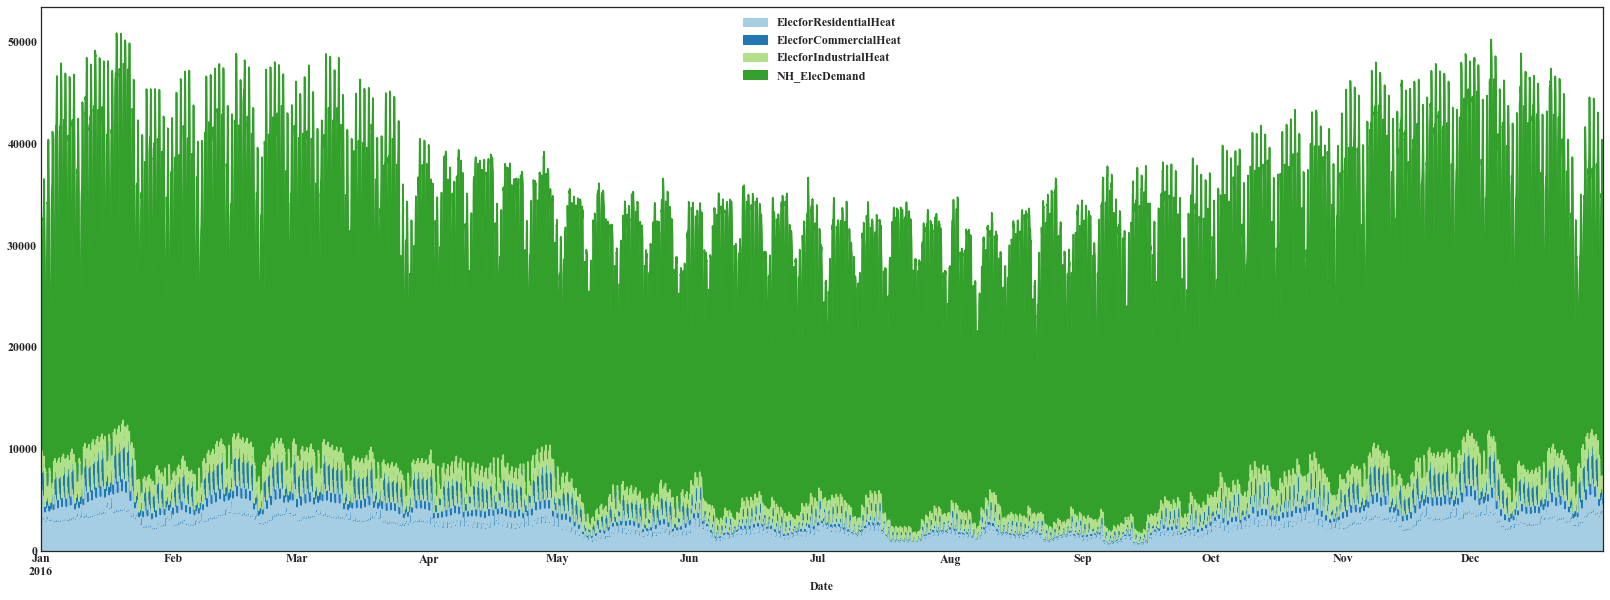

In [133]:
fig, ax = plt.subplots(figsize=(28, 10))
ax.margins(0, None)
Profiles.loc[:, ["ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat", "NH_ElecDemand"]].plot.area(ax=ax)

In [134]:
Profiles.loc[:, ["ASHP "+str(year), "GSHP "+str(year),"HybridHP "+str(year)]].sum()/2/1000000

ASHP 2020        0.955756
GSHP 2020        0.147596
HybridHP 2020    0.080620
dtype: float64

# Profiles 2025 Steady state

In [135]:
year=2025
Demand=275.218*1000 #GWh
ASHP_peak_demand= 0.8265*1000 #in MW, Based on a ADMD of 1.7kW
GSHP_peak_demand= 0.04171*1000 #in MW, Based on a ADMD of 1.7kW
Hybrid_peak_demand = 0.0607*1000
residential_resistive_consumption=30187*1000 #Electricity consumption from residential sector space heating+ hot water in MWh
commercial_sector_consumption = 11719*1000 #Electricity consumption from commercial sector space heating+ hot water in MWh
industrial_sector_consumption = 6942*1000 #Electricity consumption from industrial sector space heating+ hot water in MWh

In [136]:
Profiles=Profiles_2016[["Temperature", "Temperature cat", "Day", "Time"]].copy()

In [137]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()

In [138]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()
Profiles["GSHP "+str(year)]=Profiles_2016["Pred GSHP"]*GSHP_peak_demand/Profiles_2016["Pred GSHP"].max()
# Hybrid_peak_demand = Profiles.loc[Profiles["Temperature cat"]=="5-10", "ASHP "+str(year)].max()*(1-20/100)
Profiles["HybridHP "+str(year)]=Profiles_2016["Pred HybridHP"]*Hybrid_peak_demand/Profiles_2016["Pred HybridHP"].max()

In [139]:
Profiles["ElecforResidentialHeat"]=Profiles_2016["Residential resistive"]*residential_resistive_consumption*2/Profiles_2016["Residential resistive"].sum()
Profiles["ElecforResidentialHeat"]=Profiles["ElecforResidentialHeat"]+Profiles["HybridHP "+str(year)]+Profiles["ASHP "+str(year)]+Profiles["GSHP "+str(year)]
Profiles["ElecforCommercialHeat"]=Profiles_2016["Commercial"]*commercial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["ElecforIndustrialHeat"]=Profiles_2016["Commercial"]*industrial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["Load UK"]=Profiles_2016["Load UK"]*Demand/(Profiles_2016["Load UK"].sum()/2)
Profiles["NH_ElecDemand"]=Profiles["Load UK"]*1000 - (Profiles["ElecforResidentialHeat"]+Profiles["ElecforCommercialHeat"]+Profiles["ElecforIndustrialHeat"])

In [140]:
Profiles.loc[:, ["Day", "Time","ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat", "NH_ElecDemand"]].to_csv(path_save+"EnergyDemand_steadystate_"+str(year)+".csv")

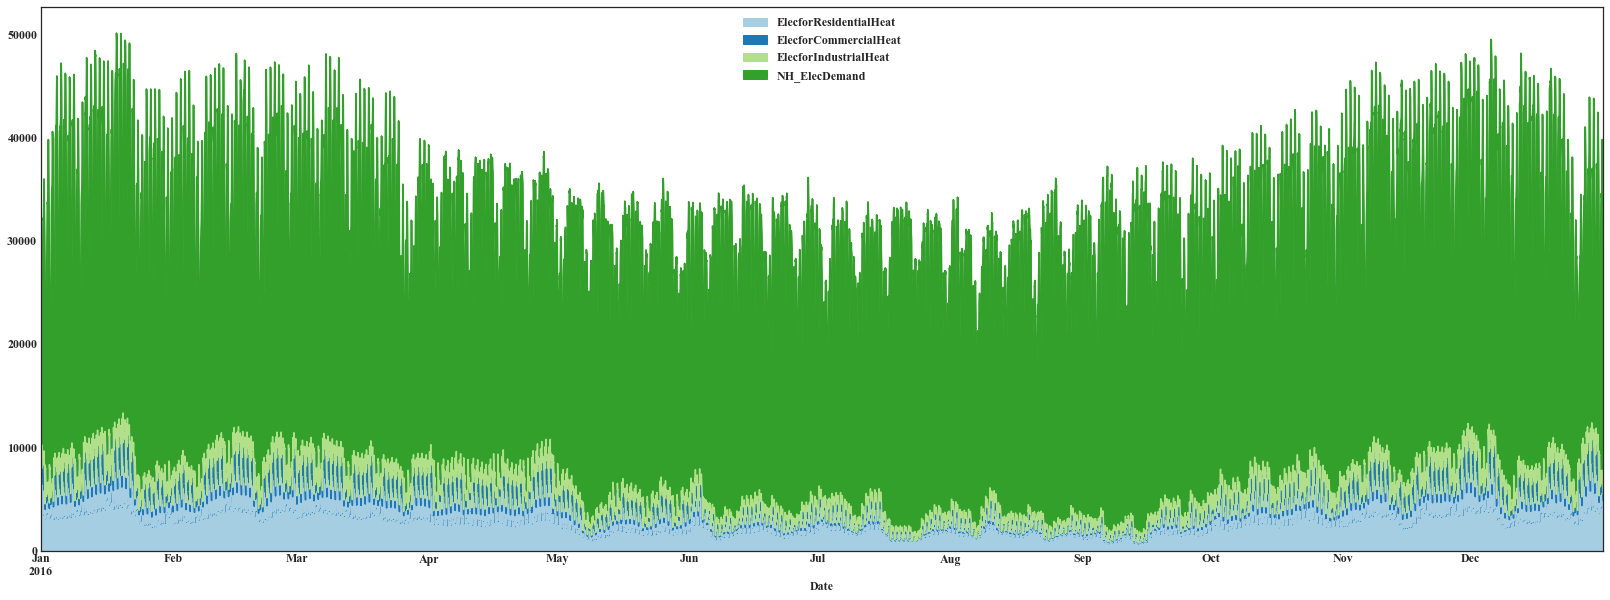

In [141]:
fig, ax = plt.subplots(figsize=(28, 10))
ax.margins(0, None)
Profiles.loc[:, ["ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat", "NH_ElecDemand"]].plot.area(ax=ax)

In [142]:
Profiles.loc[:, ["ASHP "+str(year), "GSHP "+str(year),"HybridHP "+str(year)]].sum()/2/1000000

ASHP 2025        2.253730
GSHP 2025        0.123619
HybridHP 2025    0.164935
dtype: float64

# Profiles 2030 Steady state

In [143]:
year=2030
Demand=271.250*1000 #GWh
ASHP_peak_demand= 1.1869*1000 #in MW, Based on a ADMD of 1.7kW
GSHP_peak_demand= 0.0431991*1000 #in MW, Based on a ADMD of 1.7kW
Hybrid_peak_demand = 0.160175*1000
residential_resistive_consumption=31692*1000 #Electricity consumption from residential sector space heating+ hot water in MWh
commercial_sector_consumption = 11747*1000 #Electricity consumption from commercial sector space heating+ hot water in MWh
industrial_sector_consumption = 6654*1000 #Electricity consumption from industrial sector space heating+ hot water in MWh

In [144]:
Profiles=Profiles_2016[["Temperature", "Temperature cat", "Day", "Time"]].copy()

In [145]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()

In [146]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()
Profiles["GSHP "+str(year)]=Profiles_2016["Pred GSHP"]*GSHP_peak_demand/Profiles_2016["Pred GSHP"].max()
# Hybrid_peak_demand = Profiles.loc[Profiles["Temperature cat"]=="5-10", "ASHP "+str(year)].max()*(1-20/100)
Profiles["HybridHP "+str(year)]=Profiles_2016["Pred HybridHP"]*Hybrid_peak_demand/Profiles_2016["Pred HybridHP"].max()

In [147]:
Profiles["ElecforResidentialHeat"]=Profiles_2016["Residential resistive"]*residential_resistive_consumption*2/Profiles_2016["Residential resistive"].sum()
Profiles["ElecforResidentialHeat"]=Profiles["ElecforResidentialHeat"]+Profiles["HybridHP "+str(year)]+Profiles["ASHP "+str(year)]+Profiles["GSHP "+str(year)]
Profiles["ElecforCommercialHeat"]=Profiles_2016["Commercial"]*commercial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["ElecforIndustrialHeat"]=Profiles_2016["Commercial"]*industrial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["Load UK"]=Profiles_2016["Load UK"]*Demand/(Profiles_2016["Load UK"].sum()/2)
Profiles["NH_ElecDemand"]=Profiles["Load UK"]*1000 - (Profiles["ElecforResidentialHeat"]+Profiles["ElecforCommercialHeat"]+Profiles["ElecforIndustrialHeat"])

In [148]:
Profiles.loc[:, ["Day", "Time","ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat", "NH_ElecDemand"]].to_csv(path_save+"EnergyDemand_steadystate_"+str(year)+".csv")

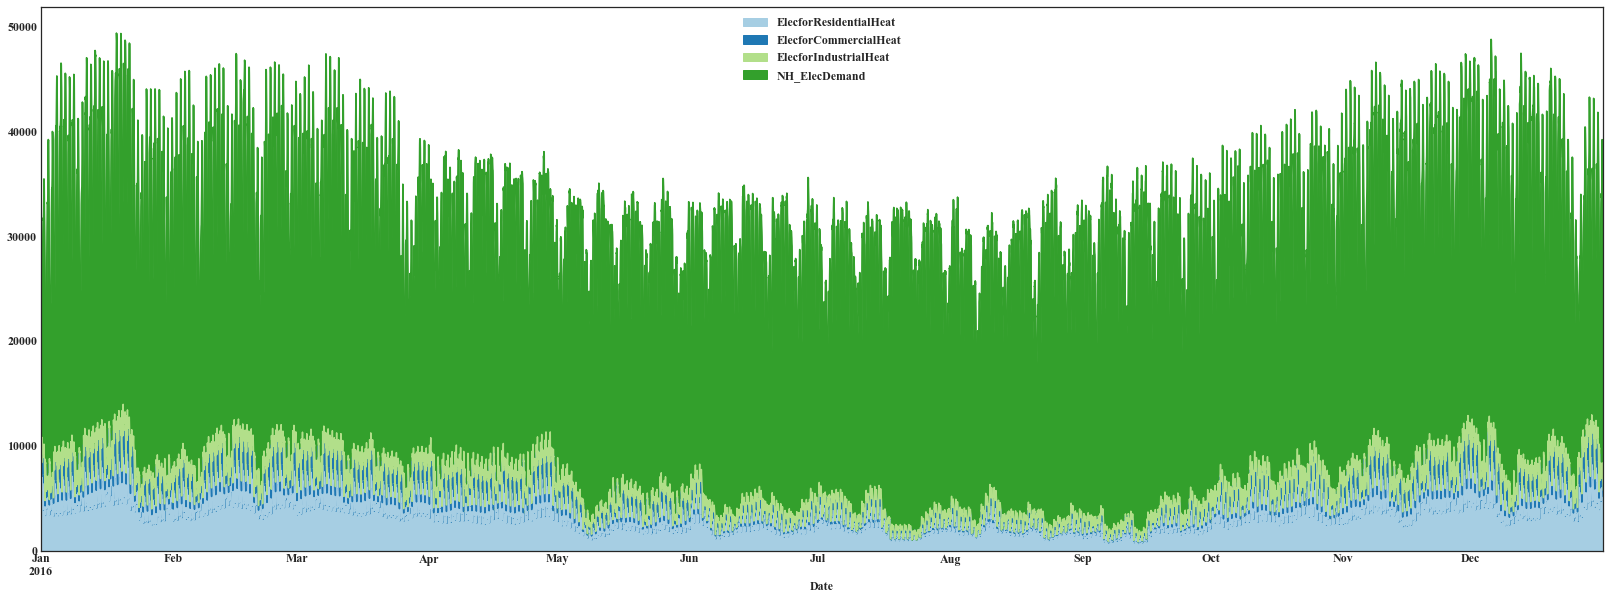

In [149]:
fig, ax = plt.subplots(figsize=(28, 10))
ax.margins(0, None)
Profiles.loc[:, ["ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat", "NH_ElecDemand"]].plot.area(ax=ax)

In [150]:
Profiles.loc[:, ["ASHP "+str(year), "GSHP "+str(year),"HybridHP "+str(year)]].sum()/2/1000000

ASHP 2030        3.236482
GSHP 2030        0.128032
HybridHP 2030    0.435231
dtype: float64

# Profiles 2030 Sensitivy 2 degrees 10%

In [151]:
year=2030
Demand=295.032*1000 #GWh
ASHP_peak_demand= 6.078804677*1000 #in MW, Based on a ADMD of 1.7kW
GSHP_peak_demand= 0.286540503*1000 #in MW, Based on a ADMD of 1.7kW
Hybrid_peak_demand = 2.441250643*1000
residential_resistive_consumption=29811*1000 #Electricity consumption from residential sector space heating+ hot water in MWh
commercial_sector_consumption = 26083*1000 #Electricity consumption from commercial sector space heating+ hot water in MWh
industrial_sector_consumption = 7683*1000 #Electricity consumption from industrial sector space heating+ hot water in MWh

In [152]:
Profiles=Profiles_2016[["Temperature", "Temperature cat", "Day", "Time"]].copy()

In [153]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()

In [154]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()
Profiles["GSHP "+str(year)]=Profiles_2016["Pred GSHP"]*GSHP_peak_demand/Profiles_2016["Pred GSHP"].max()
# Hybrid_peak_demand = Profiles.loc[Profiles["Temperature cat"]=="5-10", "ASHP "+str(year)].max()*(1-20/100)
Profiles["HybridHP "+str(year)]=Profiles_2016["Pred HybridHP"]*Hybrid_peak_demand/Profiles_2016["Pred HybridHP"].max()

In [155]:
Profiles["ElecforResidentialHeat"]=Profiles_2016["Residential resistive"]*residential_resistive_consumption*2/Profiles_2016["Residential resistive"].sum()
Profiles["ElecforResidentialHeat"]=Profiles["ElecforResidentialHeat"]+Profiles["HybridHP "+str(year)]+Profiles["ASHP "+str(year)]+Profiles["GSHP "+str(year)]
Profiles["ElecforCommercialHeat"]=Profiles_2016["Commercial"]*commercial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["ElecforIndustrialHeat"]=Profiles_2016["Commercial"]*industrial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["Load UK"]=Profiles_2016["Load UK"]*Demand/(Profiles_2016["Load UK"].sum()/2)
Profiles["NH_ElecDemand"]=Profiles["Load UK"]*1000 - (Profiles["ElecforResidentialHeat"]+Profiles["ElecforCommercialHeat"]+Profiles["ElecforIndustrialHeat"])

In [156]:
heat_consumption = Profiles.loc[:, ["ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat"]].sum().sum()/2/1000000

percentage=0.1
print(heat_consumption)

87.6355595145


In [157]:
wind_normalized= pd.read_csv(path_save+"WindSolarTemp_2016.csv", index_col=0, parse_dates=True)
wind_normalized.head()

,Day,Time,Normalised_solar,Normalised_hydro,Normalised_wind,Normalised_IC
FullDate,,,,,,
2016-01-01 00:00:00,1.0,1.0,0.0,0.514866,0.594935,0.648776
2016-01-01 00:30:00,1.0,2.0,0.0,0.477883,0.551540,0.632768
2016-01-01 01:00:00,1.0,3.0,0.0,0.466280,0.508272,0.645480
2016-01-01 01:30:00,1.0,4.0,0.0,0.465555,0.460041,0.637006
2016-01-01 02:00:00,1.0,5.0,0.0,0.465555,0.394502,0.625235


In [158]:
list_sectors=["ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat"]
total_wind=wind_normalized["Normalised_wind"].sum()
for sector in list_sectors:
    sector_consumption=Profiles[sector].sum()*percentage
    Profiles[sector]=Profiles[sector]*(1-percentage)
    Profiles[sector]=Profiles[sector]+wind_normalized["Normalised_wind"]*sector_consumption/total_wind
    
print(Profiles.loc[:, ["ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat"]].sum().sum()/2/1000000)

87.6355595145


In [159]:
Profiles.loc[:, ["Day", "Time","ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat", "NH_ElecDemand"]].to_csv(path_save+"EnergyDemand_sensitivity_"+str(year)+".csv")

# Profiles 2030 Sensitivy 2 degrees 20%

In [160]:
year=2030
Demand=295.032*1000 #GWh
ASHP_peak_demand= 6.078804677*1000 #in MW, Based on a ADMD of 1.7kW
GSHP_peak_demand= 0.286540503*1000 #in MW, Based on a ADMD of 1.7kW
Hybrid_peak_demand = 2.441250643*1000
residential_resistive_consumption=29811*1000 #Electricity consumption from residential sector space heating+ hot water in MWh
commercial_sector_consumption = 26083*1000 #Electricity consumption from commercial sector space heating+ hot water in MWh
industrial_sector_consumption = 7683*1000 #Electricity consumption from industrial sector space heating+ hot water in MWh

In [161]:
Profiles=Profiles_2016[["Temperature", "Temperature cat", "Day", "Time"]].copy()

In [162]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()

In [163]:
Profiles["ASHP "+str(year)]=Profiles_2016["Pred ASHP"]*ASHP_peak_demand/Profiles_2016["Pred ASHP"].max()
Profiles["GSHP "+str(year)]=Profiles_2016["Pred GSHP"]*GSHP_peak_demand/Profiles_2016["Pred GSHP"].max()
# Hybrid_peak_demand = Profiles.loc[Profiles["Temperature cat"]=="5-10", "ASHP "+str(year)].max()*(1-20/100)
Profiles["HybridHP "+str(year)]=Profiles_2016["Pred HybridHP"]*Hybrid_peak_demand/Profiles_2016["Pred HybridHP"].max()

In [164]:
Profiles["ElecforResidentialHeat"]=Profiles_2016["Residential resistive"]*residential_resistive_consumption*2/Profiles_2016["Residential resistive"].sum()
Profiles["ElecforResidentialHeat"]=Profiles["ElecforResidentialHeat"]+Profiles["HybridHP "+str(year)]+Profiles["ASHP "+str(year)]+Profiles["GSHP "+str(year)]
Profiles["ElecforCommercialHeat"]=Profiles_2016["Commercial"]*commercial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["ElecforIndustrialHeat"]=Profiles_2016["Commercial"]*industrial_sector_consumption*2/Profiles_2016["Commercial"].sum()
Profiles["Load UK"]=Profiles_2016["Load UK"]*Demand/(Profiles_2016["Load UK"].sum()/2)
Profiles["NH_ElecDemand"]=Profiles["Load UK"]*1000 - (Profiles["ElecforResidentialHeat"]+Profiles["ElecforCommercialHeat"]+Profiles["ElecforIndustrialHeat"])

In [165]:
heat_consumption = Profiles.loc[:, ["ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat"]].sum().sum()/2/1000000

percentage=0.2
print(heat_consumption)

87.6355595145


In [166]:
list_sectors=["ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat"]
total_wind=wind_normalized["Normalised_wind"].sum()
for sector in list_sectors:
    sector_consumption=Profiles[sector].sum()*percentage
    Profiles[sector]=Profiles[sector]*(1-percentage)
    Profiles[sector]=Profiles[sector]+wind_normalized["Normalised_wind"]*sector_consumption/total_wind
    
print(Profiles.loc[:, ["ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat"]].sum().sum()/2/1000000)

87.6355595145


In [167]:
Profiles.loc[:, ["Day", "Time","ElecforResidentialHeat", "ElecforCommercialHeat", "ElecforIndustrialHeat", "NH_ElecDemand"]].to_csv(path_save+"EnergyDemand_sensitivity2_"+str(year)+".csv")